## Import Libraries

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from IPython.display import Audio
# import resampy

## Load dataset.csv

In [6]:
def convertPath(current_directory,path):
    """
    Converts to absolute path
    """
    combined_path = os.path.join(current_directory,path)
    absolute_path = os.path.abspath(combined_path)
    return absolute_path

In [7]:
current_directory = os.getcwd()
path_to_dataset_csv = "csv/dataset.csv"

df = pd.read_csv(path_to_dataset_csv)
# Convert to absolute path
df['Path'] = df['Path'].apply(lambda x: convertPath(current_directory,x))

path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

# Data Augmentation

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

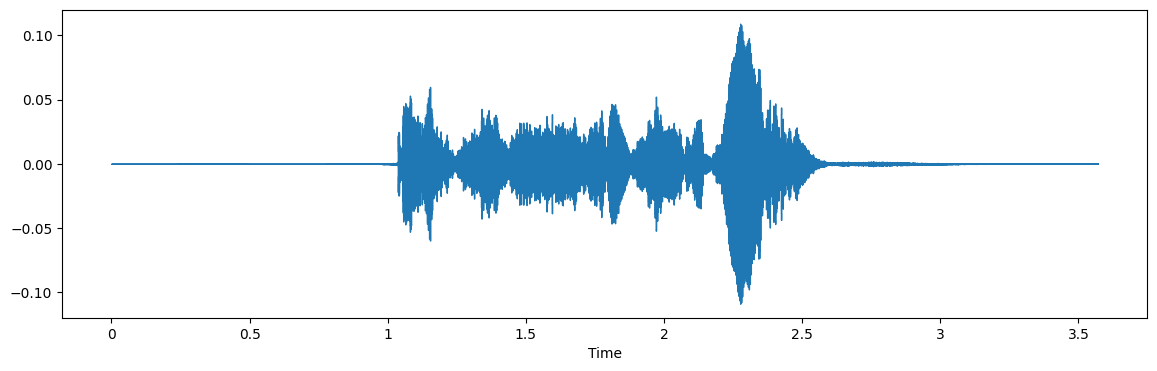

In [9]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [10]:

def extract_features(data, sample_rate):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    # Spectral Centroid
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroids))

    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))

    # Chroma Deviation
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_std))

    return result

def get_features(path):
    # TODO - Consider removing quiet parts of the audio before stitching the audio by 0.5 seconds lengths
    # This will require some calculations to get the duration and stepsize right
    
    hstack = None
    step = 5
    for i in range(0,30,step):
        
        if i == 0:
            offset=0
        else:
            i/=10
            offset = i-step/10
        print(i,offset)

        # Split audio according to the stepsize and offset
        data, sample_rate = librosa.load(path, offset=offset, duration=step/10)
        print(data)
    
        # without augmentation
        res1 = extract_features(data,sample_rate)
        result = np.array(res1)
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data,sample_rate)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch,sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        if i == 0:
            hstack = result
        else: hstack = np.hstack((hstack,result))
        print(hstack.shape)
        
    return hstack

In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  5.4090028e-06
  1.1722058e-05 -2.3756561e-06]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  5.4090028e-06
  1.1722058e-05 -2.3756561e-06]
(3, 368)
1.0 0.5
[-1.31648035e-08  1.10134508e-07 -2.17788468e-07 ... -9.83755308e-05
 -2.20069232e-05 -1.07519181e-05]
(3, 552)
1.5 1.0
[-1.9056904e-05 -1.7472468e-05 -1.0635118e-05 ... -6.1447715e-04
 -4.1253599e-03 -4.3998496e-03]
(3, 736)
2.0 1.5
[-1.1122768e-03 -5.8017176e-05  1.9765683e-03 ...  2.4125073e-02
  2.5907857e-02 -1.2884849e-02]
(3, 920)
2.5 2.0
[-0.03708092 -0.05503291 -0.01938162 ...  0.0035214   0.00481372
  0.00587299]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.7769919e-06
  3.6037532e-06 -2.1715086e-06]
(3, 552)
1.5 1.0
[ 6.4394176e-06 -2.8906277e-05 -2.6664149e-05 ... -2.5954630e-02
  1.0138484e-02 -6.3526520e-04]
(3, 736)
2.0 1.5
[-0.00727677  0.0

/Users/darrylssy/Sites/slay-fake-news/mla-env/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.0336698e-06
 -3.0136413e-05 -1.2162051e-05]
(3, 552)
1.5 1.0
[-3.1605799e-05 -6.0148581e-05 -2.2664130e-05 ... -3.8033061e-02
 -4.0851347e-02 -3.6424063e-02]
(3, 736)
2.0 1.5
[-0.01928652 -0.02998148 -0.04340312 ... -0.01371793  0.006437
  0.01609562]
(3, 920)
2.5 2.0
[-0.00374183 -0.00377451  0.00587418 ...  0.0276206   0.02862562
  0.03339247]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.85994535e-05
 -6.79505829e-05 -1.09624474e-04]
(3, 552)
1.5 1.0
[-2.4159788e-05 -7.5927695e-05 -7.6239194e-05 ...  1.3201038e-03
 -5.2964350e-04  7.7677891e-04]
(3, 736)
2.0 1.5
[ 8.7213377e-04  1.0997322e-03  5.9509421e-05 ...  7.0630835e-04
  3.9012131e-04 -2.2779031e-06]
(3, 920)
2.5 2.0
[-2.7780263e-05 -2.0393738e-04 -2.3414355e-04 ... -2.4593949e-02
 -2.4058025e-02 -2.6083436e-02]


(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.7100828e-06
  6.8567488e-06  1.0704889e-05]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.7100828e-06
  6.8567488e-06  1.0704889e-05]
(3, 368)
1.0 0.5
[-3.7027840e-07  4.1187508e-07 -4.2910671e-07 ...  6.4569147e-05
 -1.9826848e-05 -2.5911439e-05]
(3, 552)
1.5 1.0
[-1.76653950e-04 -9.33005431e-05  3.39785474e-05 ... -1.56154595e-02
  6.91450341e-03  1.27953794e-02]
(3, 736)
2.0 1.5
[-0.00590695 -0.01230248  0.02009381 ...  0.00510363  0.0044783
  0.00461904]
(3, 920)
2.5 2.0
[0.00287897 0.00410467 0.00333952 ... 0.0055988  0.00542429 0.00592554]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.7133093e-05
 -1.7887363e-05 -4.4355584e-06]
(3, 552)
1.5 1.0
[ 4.5798080e-07  7.0999431e-06  1.2215030e-05 ... -4.5695208e-04
 -3.9406016e-04 -2.2826156e-04]
(3, 736)
2.0 1.5
[-0.00019639 -0.00024256 -0.00011

(3, 368)
1.0 0.5
[ 4.3652917e-10 -5.0011068e-10  5.4060856e-10 ...  5.8783799e-06
 -4.4299700e-06  3.7528571e-06]
(3, 552)
1.5 1.0
[ 3.0901369e-06  1.2141376e-05 -7.2137636e-06 ...  7.2683585e-03
  2.5455770e-03  1.8565784e-03]
(3, 736)
2.0 1.5
[ 0.0028137   0.00737863  0.00646106 ... -0.00178673 -0.00164878
 -0.00168473]
(3, 920)
2.5 2.0
[-0.00104309 -0.00155884 -0.00117923 ... -0.00257934 -0.00307779
 -0.00447675]
(3, 1104)
0 0
[ 3.7278852e-08 -4.1487173e-08  4.3749871e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 3.7278852e-08 -4.1487173e-08  4.3749871e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[-9.1000205e-15  1.0944112e-14  4.3011215e-14 ... -2.2094829e-04
 -8.3466672e-05 -5.0097300e-05]
(3, 552)
1.5 1.0
[-5.0204020e-05 -1.3608244e-04 -9.3736118e-05 ... -2.7453607e-05
  3.1985567e-06 -1.5478543e-05]
(3, 736)
2.0 1.5
[-2.0814228e-05 -1.1899441e-05  1.8187578e-05 ... -2.6267041e-02
 -2.5882067e-02 -2.9755713e-02]
(3, 920)
2.5 

(3, 552)
1.5 1.0
[ 1.45383674e-04  1.50427179e-04  9.30928873e-05 ... -2.00414825e-02
  1.29508856e-03  1.36807095e-02]
(3, 736)
2.0 1.5
[-0.01628726  0.00395835  0.01658994 ... -0.00169772 -0.00156284
 -0.00160664]
(3, 920)
2.5 2.0
[ 0.00063286 -0.00369197 -0.00515631 ...  0.0153496   0.01610494
  0.01869153]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.9269461e-06
  3.8477119e-06 -3.2145383e-06]
(3, 552)
1.5 1.0
[ 5.7927724e-07  1.9255738e-08 -8.8746810e-06 ...  5.6165401e-03
  1.4993720e-03 -4.9483948e-03]
(3, 736)
2.0 1.5
[-0.00585012 -0.0095716  -0.0085344  ...  0.00896657  0.0077547
  0.00807471]
(3, 920)
2.5 2.0
[ 0.00521567  0.00757436  0.00586206 ... -0.0008571  -0.00090026
 -0.00115391]
(3, 1104)
0 0
[-8.65530195e-13  1.68703959e-13 -3.36495399e-13 ...  1.03910177e-04
  1.05996012e-04  1.12455156e-04]
(3, 184)
0.5 0.0
[-8.65530195e-13  1.68703959e-13 -3.36495399e-13 ...  1.

(3, 736)
2.0 1.5
[-0.00747652 -0.01136358  0.00287351 ...  0.10778243  0.10546901
  0.09424482]
(3, 920)
2.5 2.0
[0.04342038 0.05385211 0.04382578 ... 0.0129351  0.0086873  0.00682267]
(3, 1104)
0 0
[-4.0873219e-05 -6.8414141e-05 -5.3615331e-05 ... -7.8354960e-06
 -5.2509335e-05 -3.3475182e-05]
(3, 184)
0.5 0.0
[-4.0873219e-05 -6.8414141e-05 -5.3615331e-05 ... -7.8354960e-06
 -5.2509335e-05 -3.3475182e-05]
(3, 368)
1.0 0.5
[-1.0154420e-05 -3.4743411e-05 -3.9518385e-05 ...  6.7960174e-04
  4.9706333e-04  1.0060091e-03]
(3, 552)
1.5 1.0
[ 0.00083298  0.00167281  0.00119347 ... -0.00553051 -0.00559213
 -0.00598787]
(3, 736)
2.0 1.5
[-0.00365378 -0.00541366 -0.0043574  ... -0.00633154 -0.00663346
 -0.00811053]
(3, 920)
2.5 2.0
[-5.7331440e-03 -9.2178658e-03 -9.3109813e-03 ... -3.1812845e-06
 -1.7480272e-06 -3.3540713e-05]
(3, 1104)
0 0
[ 3.7965397e-05  8.0840255e-05  7.5368938e-05 ...  2.6355521e-04
 -4.9029306e-05  8.9130757e-05]
(3, 184)
0.5 0.0
[ 3.7965397e-05  8.0840255e-05  7.5368938e

(3, 736)
2.0 1.5
[ 0.01459158 -0.0255959  -0.00481779 ...  0.01757623  0.01408717
  0.01450018]
(3, 920)
2.5 2.0
[8.9834584e-03 1.2239932e-02 8.1884442e-03 ... 8.9129055e-05 1.2319999e-04
 1.0683077e-04]
(3, 1104)
0 0
[-2.5014810e-05 -2.0610865e-05  8.5544025e-07 ... -7.8491885e-06
 -1.6159867e-05 -2.2108108e-05]
(3, 184)
0.5 0.0
[-2.5014810e-05 -2.0610865e-05  8.5544025e-07 ... -7.8491885e-06
 -1.6159867e-05 -2.2108108e-05]
(3, 368)
1.0 0.5
[-9.4310444e-06 -7.3228125e-06 -2.5616131e-05 ... -7.4150630e-06
 -2.4460711e-05 -2.2589489e-05]
(3, 552)
1.5 1.0
[ 2.4059293e-05  1.1103373e-05 -4.4214325e-06 ...  2.5027106e-03
  8.7616191e-04  1.9475330e-03]
(3, 736)
2.0 1.5
[ 8.6091546e-04  1.1665627e-03  6.1662220e-05 ...  7.5902883e-04
  2.8183928e-04 -6.1889608e-05]
(3, 920)
2.5 2.0
[-4.5435707e-04 -8.1784738e-04 -9.3461154e-04 ... -4.2524255e-07
  3.6816724e-07 -3.2797064e-07]
(3, 1104)
0 0
[ 9.73196657e-05  1.36005678e-04  1.19915596e-04 ...  1.50630149e-06
 -1.35295363e-06  1.20605728e-06

(3, 736)
2.0 1.5
[0.00129802 0.00250842 0.00292226 ... 0.00129341 0.00116516 0.00133127]
(3, 920)
2.5 2.0
[0.00088377 0.00138377 0.00129145 ... 0.00112604 0.00106571 0.00114448]
(3, 1104)
0 0
[-6.2475721e-07  9.7099144e-07 -1.4589918e-06 ...  1.5680461e-04
  1.3134058e-04  1.4018589e-04]
(3, 184)
0.5 0.0
[-6.2475721e-07  9.7099144e-07 -1.4589918e-06 ...  1.5680461e-04
  1.3134058e-04  1.4018589e-04]
(3, 368)
1.0 0.5
[ 9.2204427e-05  1.4377032e-04  1.2467890e-04 ... -1.6730084e-04
 -1.9838942e-04 -1.9523359e-04]
(3, 552)
1.5 1.0
[-6.6698762e-05 -7.7522964e-05 -9.1878333e-05 ... -1.7772304e-03
 -1.6069486e-03 -1.6423772e-03]
(3, 736)
2.0 1.5
[-0.00096846 -0.00180558 -0.00122346 ... -0.00365909 -0.00307411
 -0.00247314]
(3, 920)
2.5 2.0
[-1.1605269e-03 -1.2082035e-03 -2.8996353e-04 ...  4.6286917e-07
 -3.8342586e-07  3.2030874e-07]
(3, 1104)
0 0
[3.1444240e-05 6.1105573e-05 7.2622825e-05 ... 9.8127131e-12 1.1307522e-11
 6.2580722e-12]
(3, 184)
0.5 0.0
[3.1444240e-05 6.1105573e-05 7.262282

(3, 1104)
0 0
[4.2904248e-05 8.8191169e-05 6.8137662e-05 ... 3.5003308e-05 5.1343068e-05
 5.4605895e-05]
(3, 184)
0.5 0.0
[4.2904248e-05 8.8191169e-05 6.8137662e-05 ... 3.5003308e-05 5.1343068e-05
 5.4605895e-05]
(3, 368)
1.0 0.5
[1.8704648e-05 4.3480381e-05 6.1532664e-05 ... 4.2600608e-05 7.0647264e-05
 3.6789679e-05]
(3, 552)
1.5 1.0
[ 8.0493526e-05  9.9859724e-05  1.6541780e-05 ... -1.7595413e-04
 -7.1131485e-04 -2.7238384e-03]
(3, 736)
2.0 1.5
[-0.00161405 -0.00271131 -0.00282729 ... -0.01646959 -0.01644833
 -0.01615165]
(3, 920)
2.5 2.0
[-9.0037733e-03 -1.3363285e-02 -9.2436252e-03 ...  5.1771483e-05
  4.1457104e-05  5.2429914e-05]
(3, 1104)
0 0
[ 1.0577789e-05  3.5683465e-06 -4.7871604e-06 ...  1.5513270e-04
  1.4541890e-04  1.8333178e-04]
(3, 184)
0.5 0.0
[ 1.0577789e-05  3.5683465e-06 -4.7871604e-06 ...  1.5513270e-04
  1.4541890e-04  1.8333178e-04]
(3, 368)
1.0 0.5
[ 1.1919756e-04  1.1880480e-04  1.3869701e-04 ... -9.3973838e-05
 -1.4221384e-04 -1.6167729e-04]
(3, 552)
1.5 1.0

(3, 920)
2.5 2.0
[ 0.00293446  0.00194327 -0.00029127 ... -0.00033235 -0.0001363
 -0.00126344]
(3, 1104)
0 0
[4.3375881e-06 2.6582862e-05 2.7512313e-05 ... 1.0489038e-04 7.4190517e-05
 9.4427814e-05]
(3, 184)
0.5 0.0
[4.3375881e-06 2.6582862e-05 2.7512313e-05 ... 1.0489038e-04 7.4190517e-05
 9.4427814e-05]
(3, 368)
1.0 0.5
[ 6.28903072e-05  1.00397454e-04  8.41275178e-05 ... -1.87032181e-03
 -1.79918436e-03 -1.99070876e-03]
(3, 552)
1.5 1.0
[-0.00139471 -0.00205242 -0.00165646 ...  0.04398663  0.02581231
  0.03411759]
(3, 736)
2.0 1.5
[0.03135116 0.04941522 0.02202891 ... 0.00991085 0.00372821 0.01032412]
(3, 920)
2.5 2.0
[ 0.01715213  0.0344969   0.01476235 ... -0.00459559 -0.00422104
 -0.00425775]
(3, 1104)
0 0
[ 1.2780791e-07 -1.7890262e-07  2.1308075e-07 ...  2.1482280e-03
  2.0355582e-03  2.2212574e-03]
(3, 184)
0.5 0.0
[ 1.2780791e-07 -1.7890262e-07  2.1308075e-07 ...  2.1482280e-03
  2.0355582e-03  2.2212574e-03]
(3, 368)
1.0 0.5
[0.00142586 0.00221506 0.00200066 ... 0.00137641 

(3, 1104)
0 0
[ 3.3336788e-12 -5.2225754e-12  7.1593395e-12 ...  6.5517253e-10
 -4.9933313e-10  3.6570202e-10]
(3, 184)
0.5 0.0
[ 3.3336788e-12 -5.2225754e-12  7.1593395e-12 ...  6.5517253e-10
 -4.9933313e-10  3.6570202e-10]
(3, 368)
1.0 0.5
[ 4.3589174e-10 -4.9767457e-10  5.3669874e-10 ... -1.2853670e-06
  1.8342145e-05 -2.0045907e-06]
(3, 552)
1.5 1.0
[-2.3740552e-06  3.3355602e-06 -5.0963267e-06 ... -8.2638096e-03
 -1.1704708e-02 -1.3589976e-02]
(3, 736)
2.0 1.5
[-0.00878543 -0.01018604 -0.00324698 ... -0.00433023 -0.00455664
 -0.00516152]
(3, 920)
2.5 2.0
[-0.00328142 -0.00464845 -0.00381526 ...  0.00032006  0.00026988
  0.00031846]
(3, 1104)
0 0
[-9.9712227e-10  1.9915141e-09 -2.8065847e-09 ... -1.2957486e-07
  1.2436644e-07 -1.1702604e-07]
(3, 184)
0.5 0.0
[-9.9712227e-10  1.9915141e-09 -2.8065847e-09 ... -1.2957486e-07
  1.2436644e-07 -1.1702604e-07]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.6192424e-06
  5.6809580e-07 -6.8149907e-06]
(3, 552)
1.5 1.0

(3, 920)
2.5 2.0
[-0.07755137 -0.08458006 -0.02106806 ...  0.00019637  0.00262038
  0.00386301]
(3, 1104)
0 0
[-8.9188216e-13 -7.6765417e-14 -4.5729501e-13 ...  9.7947053e-15
 -5.6992842e-14  2.1513077e-14]
(3, 184)
0.5 0.0
[-8.9188216e-13 -7.6765417e-14 -4.5729501e-13 ...  9.7947053e-15
 -5.6992842e-14  2.1513077e-14]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.1678032e-06 1.0008872e-05
 4.7212443e-06]
(3, 552)
1.5 1.0
[ 1.2105340e-05  9.2495483e-08  3.5335546e-05 ...  1.0256953e-01
  3.2432541e-02 -9.9915095e-02]
(3, 736)
2.0 1.5
[-0.12648356 -0.23245072 -0.25973004 ... -0.22522181 -0.16609967
 -0.14513871]
(3, 920)
2.5 2.0
[-0.13283095 -0.22994652 -0.17415021 ...  0.3156519   0.38815966
  0.4813703 ]
(3, 1104)
0 0
[ 1.5851023e-07 -1.3782963e-07  1.1430189e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 1.5851023e-07 -1.3782963e-07  1.1430189e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[-1.6970805e-14 -5.3412

(3, 736)
2.0 1.5
[-8.01314891e-05 -1.14099406e-04 -9.79121905e-05 ...  2.97656637e-02
  2.68540867e-02  2.61368863e-02]
(3, 920)
2.5 2.0
[0.0156704  0.02299491 0.01799123 ... 0.05106562 0.03770517 0.02642552]
(3, 1104)
0 0
[ 5.2725551e-14 -4.9379771e-14 -2.9455456e-14 ...  1.5921660e-14
 -8.1652451e-14 -1.5007407e-13]
(3, 184)
0.5 0.0
[ 5.2725551e-14 -4.9379771e-14 -2.9455456e-14 ...  1.5921660e-14
 -8.1652451e-14 -1.5007407e-13]
(3, 368)
1.0 0.5
[-4.6587717e-14  5.2191124e-14 -3.8243771e-14 ...  1.7812749e-06
 -1.0279687e-06  7.7111753e-07]
(3, 552)
1.5 1.0
[ 6.2481326e-05 -6.5092929e-05  6.7596673e-05 ...  4.4606929e-03
  2.2504028e-02  2.6371645e-02]
(3, 736)
2.0 1.5
[ 0.00378774  0.01607495  0.02880517 ... -0.003453   -0.00291136
 -0.00238519]
(3, 920)
2.5 2.0
[-1.1265337e-03 -9.5601217e-04  4.2888376e-05 ...  1.1256759e-03
  1.1299113e-03  1.1662709e-03]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.0909437e-16 2.7788286e-13
 3.7688434e-13]
(3, 184)
0.5 0.0
[0.000

(3, 736)
2.0 1.5
[0.00417823 0.00648049 0.00369432 ... 0.00493946 0.00481983 0.00520897]
(3, 920)
2.5 2.0
[0.00329603 0.00526107 0.00506008 ... 0.00100726 0.00092116 0.00079542]
(3, 1104)
0 0
[ 4.8907026e-13  1.6853452e-13 -2.0278866e-13 ... -1.1618715e-04
 -2.7660708e-04 -2.2931010e-04]
(3, 184)
0.5 0.0
[ 4.8907026e-13  1.6853452e-13 -2.0278866e-13 ... -1.1618715e-04
 -2.7660708e-04 -2.2931010e-04]
(3, 368)
1.0 0.5
[-1.89630173e-05  2.83103127e-05  1.49778774e-04 ... -1.08787353e-04
 -1.13432514e-04 -1.19282158e-04]
(3, 552)
1.5 1.0
[-9.57211814e-05 -5.60894623e-05 -2.07474682e-06 ...  1.31358355e-02
  2.08912306e-02  4.46850918e-02]
(3, 736)
2.0 1.5
[ 0.0352651   0.05160381  0.03658848 ... -0.22009668 -0.22232185
 -0.22986098]
(3, 920)
2.5 2.0
[-0.1247106  -0.2145654  -0.12113652 ...  0.11811233  0.10384319
  0.08411305]
(3, 1104)
0 0
[ 4.6600331e-11 -5.1732538e-11  5.5343077e-11 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 4.6600331e-11 -5.1732538e-11  5.534

(3, 552)
1.5 1.0
[-0.00228578 -0.00172684 -0.00055186 ...  0.0023225   0.00323967
 -0.00697931]
(3, 736)
2.0 1.5
[ 0.00190779  0.00270373 -0.00703493 ...  0.00337631  0.00304537
  0.00337541]
(3, 920)
2.5 2.0
[ 0.00227525  0.00310475  0.00233945 ... -0.00074955 -0.0004014
 -0.00029845]
(3, 1104)
0 0
[ 1.2847726e-08  2.8496116e-08 -6.1197277e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 1.2847726e-08  2.8496116e-08 -6.1197277e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0772929e-08 2.9906638e-05
 1.7537481e-06]
(3, 552)
1.5 1.0
[ 8.7607405e-06  7.9177325e-06  5.9480340e-06 ...  8.6209475e-05
 -5.7265605e-04  8.9068227e-03]
(3, 736)
2.0 1.5
[ 0.00438583 -0.0092413   0.00606836 ... -0.00050055 -0.00062402
 -0.00124668]
(3, 920)
2.5 2.0
[-0.00155663 -0.00345054 -0.00472427 ...  0.00516696  0.01040494
  0.0167626 ]
(3, 1104)
0 0
[-7.1847232e-13 -3.3382349e-13 -1.1180616e-13 ... -4.5319100

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.2523520e-06
 -3.2868088e-06  1.3847001e-05]
(3, 552)
1.5 1.0
[ 5.8304406e-05  1.8764760e-05 -2.0243813e-05 ... -3.6889149e-04
 -7.3604478e-04 -1.5695834e-03]
(3, 736)
2.0 1.5
[-0.00055164  0.00095347  0.00237402 ...  0.00159468  0.00178033
  0.00238545]
(3, 920)
2.5 2.0
[0.00194453 0.00341496 0.00301936 ... 0.00085282 0.0006003  0.00036942]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.2808828e-07
  2.7780717e-07 -3.0891371e-07]
(3, 552)
1.5 1.0
[-2.6798216e-07  2.4665326e-07 -2.1915983e-07 ... -4.6578463e-04
 -1.7857499e-03  3.1267833e-03]
(3, 736)
2.0 1.5
[-2.09032954e-03  2.65206821e-04  2.09184189e-04 ... -3.95372888e-04
  4.91300598e-05 -1.03855826e-04]
(3, 920)
2.5 2.0
[-3.2033573e-04 -7.3913921e-05 -1.2814639e-04 ...  6.8278593e-04

(3, 184)
0.5 0.0
[-9.2949340e-06 -8.2162342e-06  2.8824727e-06 ... -5.2541128e-04
 -8.7873585e-04  5.9290801e-04]
(3, 368)
1.0 0.5
[ 0.00024174  0.00106164 -0.00027567 ...  0.00013614  0.00055869
 -0.00065879]
(3, 552)
1.5 1.0
[-0.00020514  0.0003694   0.00028263 ...  0.00890908 -0.00419897
 -0.00452625]
(3, 736)
2.0 1.5
[ 0.0059061   0.00174386 -0.00908107 ...  0.01996214  0.01955111
  0.02672605]
(3, 920)
2.5 2.0
[ 0.01616096  0.021673    0.01911453 ... -0.00207848 -0.00253388
 -0.00263711]
(3, 1104)
0 0
[-0.00031903 -0.00155751 -0.00022672 ...  0.00153064  0.00047518
 -0.00123942]
(3, 184)
0.5 0.0
[-0.00031903 -0.00155751 -0.00022672 ...  0.00153064  0.00047518
 -0.00123942]
(3, 368)
1.0 0.5
[-0.00044113  0.00041554  0.00259024 ... -0.00032201 -0.00042705
 -0.00040903]
(3, 552)
1.5 1.0
[-2.43346458e-05  1.11094196e-04  9.62393460e-05 ... -3.28803025e-02
 -1.12117799e-02  3.19844224e-02]
(3, 736)
2.0 1.5
[ 0.02959359  0.03587656 -0.00723507 ...  0.12810828  0.16816767
  0.24638684]
(

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.7863212e-09
 -1.6339630e-09  6.8169381e-10]
(3, 552)
1.5 1.0
[-2.1323411e-08  1.7756097e-08 -1.3874654e-08 ... -9.7293210e-05
  2.3295120e-03 -5.1800831e-04]
(3, 736)
2.0 1.5
[-6.9432473e-04  5.6652969e-04  1.3966267e-03 ...  4.0606337e-04
  2.7899878e-04 -3.6415131e-05]
(3, 920)
2.5 2.0
[-0.0003271  -0.00074173 -0.0008919  ...  0.00044249  0.00038048
  0.00029905]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  7.5872967e-06
  8.1048020e-06 -3.0986204e-05]
(3, 552)
1.5 1.0
[-9.9653562e-06 -1.8362502e-05 -1.9985320e-05 ...  4.1989353e-03
 -2.4521712e-03  2.5530203e-04]
(3, 736)
2.0 1.5
[-0.00551658  0.00644243 -0.00099773 ...  0.00601419  0.00564503
  0.00583376]
(3, 920)
2.5 2.0
[0.00357351 0.00586311 0.00500825 ... 0.00588937 0.00568375 0.0

(3, 736)
2.0 1.5
[ 0.0051403  -0.00159795  0.01126301 ...  0.00325462  0.0007012
 -0.00412587]
(3, 920)
2.5 2.0
[-0.00292956 -0.00536215 -0.00523403 ... -0.01835472 -0.01847257
 -0.00619199]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6623559e-06
 -1.1696760e-05 -1.0642055e-05]
(3, 552)
1.5 1.0
[ 1.0219122e-06 -1.2614781e-06  1.4120504e-06 ...  9.9051818e-03
 -1.8906172e-03 -1.2990921e-03]
(3, 736)
2.0 1.5
[-1.4707793e-03  1.0590398e-03  1.9166948e-03 ... -9.0070425e-05
 -1.1094813e-03 -3.5954190e-03]
(3, 920)
2.5 2.0
[-0.00851614 -0.0253325  -0.03700738 ... -0.00356945 -0.00022842
  0.00484488]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.9480306e-08
 -1.0474762e-07  1.4957563e-07]
(3, 552)
1.5 1.0
[-1.3747040e-06  1.7222305e-06 -2.1027413e-06 ... -1.0057141e-04
 -1.3867480e-04 -

(3, 552)
1.5 1.0
[-0.00460816 -0.0010444   0.00506732 ...  0.00694121  0.00147214
 -0.00575192]
(3, 736)
2.0 1.5
[ 3.2208399e-03 -2.5077688e-03  5.2725482e-03 ... -4.7830155e-04
 -3.2351334e-05 -7.4157862e-05]
(3, 920)
2.5 2.0
[-0.0007037  -0.00243362 -0.0041105  ...  0.04315149  0.04207974
  0.02533587]
(3, 1104)
0 0
[-1.7414022e-13 -2.0875220e-13  1.0939911e-12 ...  3.1987389e-07
 -1.7197574e-07  9.6793976e-08]
(3, 184)
0.5 0.0
[-1.7414022e-13 -2.0875220e-13  1.0939911e-12 ...  3.1987389e-07
 -1.7197574e-07  9.6793976e-08]
(3, 368)
1.0 0.5
[ 6.9296078e-08 -1.1505199e-07  1.4785672e-07 ... -6.9544213e-03
 -8.6939931e-03 -3.8104705e-03]
(3, 552)
1.5 1.0
[ 0.00207213  0.00415453 -0.00052422 ...  0.00376802  0.01088398
  0.01183608]
(3, 736)
2.0 1.5
[-0.00188176 -0.03163114 -0.06703091 ...  0.00013208  0.00021657
  0.00041098]
(3, 920)
2.5 2.0
[0.00029501 0.00056022 0.00076007 ... 0.01820491 0.01704698 0.01953482]
(3, 1104)
0 0
[ 2.8879030e-12 -4.3238863e-12  6.5578827e-12 ...  2.5593852

(3, 552)
1.5 1.0
[-0.00014771 -0.00015722 -0.00020861 ... -0.00243571 -0.0020507
  0.05427257]
(3, 736)
2.0 1.5
[-0.04795519 -0.01392169  0.0745272  ...  0.00543187  0.00589282
  0.00688715]
(3, 920)
2.5 2.0
[ 0.00461377  0.00733232  0.00671428 ... -0.00971465 -0.00784731
 -0.00619055]
(3, 1104)
0 0
[ 2.4663214e-11 -3.6219746e-11  4.8777395e-11 ...  5.2715983e-09
 -4.3599067e-09  3.4983527e-09]
(3, 184)
0.5 0.0
[ 2.4663214e-11 -3.6219746e-11  4.8777395e-11 ...  5.2715983e-09
 -4.3599067e-09  3.4983527e-09]
(3, 368)
1.0 0.5
[ 1.5129679e-08 -1.7875054e-08  1.9145567e-08 ...  1.4191959e-04
  6.0599476e-05  1.0172246e-04]
(3, 552)
1.5 1.0
[ 5.5182438e-05  6.5276326e-05  8.6525208e-05 ...  5.5800722e-04
 -2.7218147e-03  4.2238617e-03]
(3, 736)
2.0 1.5
[-4.9930005e-03 -7.0194560e-03  3.6670885e-03 ... -5.0319114e-04
 -8.4134430e-05  1.5990806e-04]
(3, 920)
2.5 2.0
[0.00042262 0.00066127 0.0005685  ... 0.01395302 0.01450085 0.01628914]
(3, 1104)
0 0
[ 1.2752573e-05  5.5155931e-07 -6.2497429e-

(3, 368)
1.0 0.5
[ 1.4426109e-07 -1.8507259e-07  2.1113570e-07 ...  1.5474081e-05
  4.5041146e-05  3.6411919e-05]
(3, 552)
1.5 1.0
[ 3.4272016e-05  5.0247399e-05  1.6663051e-05 ...  3.6654271e-02
 -2.6501093e-02 -2.4655312e-02]
(3, 736)
2.0 1.5
[ 0.01499937  0.02871652 -0.0232376  ... -0.02538152 -0.01721299
 -0.00448914]
(3, 920)
2.5 2.0
[0.00711477 0.02286554 0.03609619 ... 0.02216334 0.02239138 0.02595638]
(3, 1104)
0 0
[ 5.4368365e-07 -8.1199664e-07  1.1247507e-06 ... -1.7077100e-06
  2.8826096e-06 -8.2411016e-06]
(3, 184)
0.5 0.0
[ 5.4368365e-07 -8.1199664e-07  1.1247507e-06 ... -1.7077100e-06
  2.8826096e-06 -8.2411016e-06]
(3, 368)
1.0 0.5
[ 4.4919126e-08  3.8987125e-08 -1.1528228e-07 ...  3.7641053e-03
 -4.3221856e-03 -5.3825490e-03]
(3, 552)
1.5 1.0
[-0.0038142   0.00484168  0.00276959 ... -0.02580765 -0.04251854
 -0.06121083]
(3, 736)
2.0 1.5
[-0.04039254 -0.05463314 -0.03297039 ... -0.00026238 -0.00025369
 -0.0003557 ]
(3, 920)
2.5 2.0
[-0.00023806 -0.00035118 -0.00028352 ..

(3, 552)
1.5 1.0
[-2.9230083e-05 -2.8742814e-05  1.0128301e-05 ...  2.1077067e-02
  4.7673867e-03 -1.2161400e-03]
(3, 736)
2.0 1.5
[ 0.00346092  0.00496125 -0.00281145 ...  0.01544104  0.01542168
  0.0171129 ]
(3, 920)
2.5 2.0
[0.01138382 0.01774715 0.01654092 ... 0.00415823 0.01108733 0.01861908]
(3, 1104)
0 0
[ 2.6012714e-07  1.6038302e-07 -8.3261972e-07 ... -3.6129075e-10
  2.0066185e-10 -6.7876094e-11]
(3, 184)
0.5 0.0
[ 2.6012714e-07  1.6038302e-07 -8.3261972e-07 ... -3.6129075e-10
  2.0066185e-10 -6.7876094e-11]
(3, 368)
1.0 0.5
[-3.4500577e-08  4.0754877e-08 -4.4441169e-08 ...  2.5964083e-04
 -9.1279340e-05  9.8208350e-04]
(3, 552)
1.5 1.0
[ 0.00074022  0.00062392  0.00018515 ... -0.00823868 -0.00123042
  0.0035218 ]
(3, 736)
2.0 1.5
[ 0.00646252 -0.00119219 -0.00431228 ... -0.00278055 -0.00308995
 -0.00390867]
(3, 920)
2.5 2.0
[-2.6609364e-03 -3.9157742e-03 -3.1835898e-03 ...  1.4654564e-04
  3.9045397e-05  9.7720411e-05]
(3, 1104)
0 0
[ 1.6619530e-11 -2.1685168e-11  2.2065542e

(3, 552)
1.5 1.0
[ 9.6757191e-08  5.3728709e-08 -2.7861014e-07 ... -6.6575449e-04
 -8.3680288e-04 -1.9642466e-03]
(3, 736)
2.0 1.5
[-0.00188865 -0.00338672 -0.00388234 ...  0.00274154  0.00312614
  0.00375668]
(3, 920)
2.5 2.0
[ 0.00270347  0.00387612  0.0030805  ... -0.00621747 -0.00595908
 -0.00597673]
(3, 1104)
0 0
[-8.3159534e-08  1.3365290e-08  7.2098175e-08 ...  2.8760496e-06
  1.8410503e-05  8.5021820e-06]
(3, 184)
0.5 0.0
[-8.3159534e-08  1.3365290e-08  7.2098175e-08 ...  2.8760496e-06
  1.8410503e-05  8.5021820e-06]
(3, 368)
1.0 0.5
[-9.0286125e-07  1.0334969e-06 -1.1590857e-06 ... -6.0280365e-07
  4.0875901e-07 -2.3960953e-07]
(3, 552)
1.5 1.0
[-2.29883199e-06  2.98030318e-06 -5.33542425e-06 ... -1.39879100e-02
 -1.18368501e-02 -1.26797175e-02]
(3, 736)
2.0 1.5
[-0.0086593  -0.0134308  -0.01005406 ... -0.00085416 -0.00136216
 -0.00207796]
(3, 920)
2.5 2.0
[-0.00214369 -0.00392821 -0.00388664 ...  0.00100796  0.00093586
  0.00101789]
(3, 1104)
0 0
[-8.90748342e-05 -1.24886050e

(3, 552)
1.5 1.0
[-3.5993947e-04 -1.1058209e-05  2.5396964e-03 ...  2.8579985e-03
  9.0129003e-03 -7.1431845e-03]
(3, 736)
2.0 1.5
[-0.01038335  0.00074742  0.01189803 ...  0.00694801  0.00706555
  0.00742221]
(3, 920)
2.5 2.0
[ 0.0051216   0.00852794  0.00852109 ...  0.00566526  0.00259642
 -0.00125558]
(3, 1104)
0 0
[2.6154619e-06 1.0590681e-05 4.8367277e-05 ... 3.2816883e-04 3.2061292e-04
 3.7239006e-04]
(3, 184)
0.5 0.0
[2.6154619e-06 1.0590681e-05 4.8367277e-05 ... 3.2816883e-04 3.2061292e-04
 3.7239006e-04]
(3, 368)
1.0 0.5
[ 0.00021271  0.00042705  0.00039053 ... -0.00069823 -0.00052142
 -0.00062081]
(3, 552)
1.5 1.0
[-0.00043899 -0.00062332 -0.00058505 ...  0.06027169  0.06597181
  0.05220041]
(3, 736)
2.0 1.5
[ 0.02357322  0.04477264  0.04923902 ... -0.0080134  -0.06983799
 -0.11098046]
(3, 920)
2.5 2.0
[-0.05504525 -0.00794415  0.05374978 ...  0.00354116  0.00391044
  0.0075915 ]
(3, 1104)
0 0
[ 3.8257291e-05  2.0461413e-05 -1.4447187e-06 ... -3.9291754e-05
 -8.1158450e-06 -6

(3, 736)
2.0 1.5
[-0.00053885 -0.00110109 -0.00113718 ...  0.003841    0.00370536
  0.00408481]
(3, 920)
2.5 2.0
[0.00260313 0.00372348 0.00273345 ... 0.00046013 0.00110107 0.00101101]
(3, 1104)
0 0
[ 8.2471126e-07 -1.2120453e-06  1.6220860e-06 ... -5.7967980e-05
 -6.7529436e-05 -7.4113450e-05]
(3, 184)
0.5 0.0
[ 8.2471126e-07 -1.2120453e-06  1.6220860e-06 ... -5.7967980e-05
 -6.7529436e-05 -7.4113450e-05]
(3, 368)
1.0 0.5
[-2.1522061e-05 -5.4767555e-05 -7.3197742e-05 ... -4.6505890e-04
  5.4555319e-05 -9.2944485e-04]
(3, 552)
1.5 1.0
[-0.00120616 -0.00172373 -0.00023992 ...  0.00088235  0.00056731
  0.00156071]
(3, 736)
2.0 1.5
[1.6033399e-03 1.8537053e-03 4.3789158e-05 ... 8.2468120e-03 8.2541611e-03
 1.0052858e-02]
(3, 920)
2.5 2.0
[0.00664808 0.01022813 0.00933641 ... 0.00138889 0.00231548 0.0038419 ]
(3, 1104)
0 0
[0.00045258 0.00076207 0.00085707 ... 0.00020991 0.00019803 0.00025169]
(3, 184)
0.5 0.0
[0.00045258 0.00076207 0.00085707 ... 0.00020991 0.00019803 0.00025169]
(3, 368)

(3, 736)
2.0 1.5
[-0.00401472 -0.00272751  0.00097882 ...  0.00823151  0.00828894
  0.00860404]
(3, 920)
2.5 2.0
[0.00554849 0.00869548 0.007782   ... 0.02915937 0.02677612 0.0262095 ]
(3, 1104)
0 0
[2.6603127e-05 5.3561551e-05 3.0156227e-05 ... 4.3328717e-05 2.8331950e-05
 1.9061017e-05]
(3, 184)
0.5 0.0
[2.6603127e-05 5.3561551e-05 3.0156227e-05 ... 4.3328717e-05 2.8331950e-05
 1.9061017e-05]
(3, 368)
1.0 0.5
[ 1.9081139e-05  4.3947875e-05  5.3649714e-05 ... -3.7968854e-04
 -3.3504327e-04 -3.9298536e-04]
(3, 552)
1.5 1.0
[-0.00027567 -0.00032718 -0.00034588 ... -0.00131128 -0.00124168
 -0.00064283]
(3, 736)
2.0 1.5
[ 4.1998246e-05 -5.0371973e-04 -8.1519329e-04 ... -3.5629678e-03
 -3.4326022e-03 -3.5641799e-03]
(3, 920)
2.5 2.0
[-0.00229466 -0.00366261 -0.00324769 ...  0.00011377  0.0001356
  0.00010472]
(3, 1104)
0 0
[-2.9070306e-05 -4.4169665e-05 -3.8156992e-05 ...  1.6408862e-07
 -1.5453141e-07  1.4398175e-07]
(3, 184)
0.5 0.0
[-2.9070306e-05 -4.4169665e-05 -3.8156992e-05 ...  1.64

(3, 552)
1.5 1.0
[-0.00037186 -0.00055827 -0.00050432 ...  0.00052977 -0.00107706
 -0.00351708]
(3, 736)
2.0 1.5
[-0.00464905 -0.01140868 -0.01623077 ...  0.02463026  0.02672736
  0.0276314 ]
(3, 920)
2.5 2.0
[0.01435694 0.01523871 0.00980499 ... 0.01054742 0.03920523 0.01036873]
(3, 1104)
0 0
[ 1.1666800e-07 -2.2503590e-08 -6.6775250e-08 ... -1.9700033e-06
  3.1699876e-06 -8.5440115e-06]
(3, 184)
0.5 0.0
[ 1.1666800e-07 -2.2503590e-08 -6.6775250e-08 ... -1.9700033e-06
  3.1699876e-06 -8.5440115e-06]
(3, 368)
1.0 0.5
[ 7.5571768e-07 -8.2471496e-07  8.5624004e-07 ... -2.7249643e-04
  1.3817772e-03  8.7420654e-04]
(3, 552)
1.5 1.0
[-0.0006771  -0.00236493 -0.00089867 ... -0.0001827  -0.00019165
 -0.00019854]
(3, 736)
2.0 1.5
[-0.00013643 -0.00018775 -0.00014964 ... -0.00223136  0.00149279
 -0.00661607]
(3, 920)
2.5 2.0
[-0.01117775 -0.01727889 -0.00823149 ... -0.00539505 -0.00564468
 -0.00623578]
(3, 1104)
0 0
[2.2272585e-05 5.4097734e-05 6.6501772e-05 ... 3.7642363e-05 3.7515092e-05
 2.

(3, 552)
1.5 1.0
[4.07356856e-05 1.18170865e-05 3.15058205e-05 ... 8.80945474e-03
 9.32759419e-03 1.15893055e-02]
(3, 736)
2.0 1.5
[0.00745448 0.01002006 0.00476424 ... 0.00190879 0.00128619 0.00196872]
(3, 920)
2.5 2.0
[0.00226846 0.00649191 0.00942803 ... 0.12808622 0.13173874 0.1400723 ]
(3, 1104)
0 0
[-3.3614764e-05  1.1137158e-04  1.6821946e-04 ...  3.2077656e-05
  3.8240334e-05  8.2524111e-06]
(3, 184)
0.5 0.0
[-3.3614764e-05  1.1137158e-04  1.6821946e-04 ...  3.2077656e-05
  3.8240334e-05  8.2524111e-06]
(3, 368)
1.0 0.5
[-2.1343056e-05 -6.1408886e-05 -9.4240517e-05 ... -5.2858137e-05
 -5.9084785e-05  5.0851089e-05]
(3, 552)
1.5 1.0
[ 3.5164372e-05  6.9536145e-05  1.8040197e-05 ... -2.4916032e-02
 -2.0989414e-02  2.4979862e-03]
(3, 736)
2.0 1.5
[-0.00294849  0.00123457 -0.00917722 ... -0.08156919 -0.07297657
 -0.05042953]
(3, 920)
2.5 2.0
[-0.00771322  0.04075348  0.09653534 ... -0.11029629 -0.09827433
 -0.09279448]
(3, 1104)
0 0
[2.0565263e-05 1.7645672e-05 3.2379325e-05 ... 1.

(3, 552)
1.5 1.0
[2.0207892e-05 7.3112002e-05 3.7147944e-05 ... 3.7892063e-03 4.3056686e-03
 4.9212677e-03]
(3, 736)
2.0 1.5
[ 0.00345255  0.00550485  0.00515005 ...  0.02653596 -0.00759889
 -0.01288373]
(3, 920)
2.5 2.0
[ 0.01257844 -0.03579351  0.03165866 ...  0.00624508  0.00487205
  0.00820436]
(3, 1104)
0 0
[-4.8404869e-05 -6.2994310e-05 -7.2316929e-05 ...  1.4664821e-05
 -1.4648529e-05 -5.6682336e-05]
(3, 184)
0.5 0.0
[-4.8404869e-05 -6.2994310e-05 -7.2316929e-05 ...  1.4664821e-05
 -1.4648529e-05 -5.6682336e-05]
(3, 368)
1.0 0.5
[-1.1778506e-05  4.2920830e-05  7.5133023e-05 ...  2.2871835e-05
 -6.9216207e-05 -6.5416920e-05]
(3, 552)
1.5 1.0
[-4.2621628e-05  4.0512954e-05  2.7541870e-05 ...  3.1158489e-03
 -3.7604612e-03  4.7138026e-03]
(3, 736)
2.0 1.5
[-0.00786519  0.0053548  -0.0122775  ... -0.00381253 -0.00340193
 -0.00185503]
(3, 920)
2.5 2.0
[-0.0007781  -0.0003142   0.00013286 ... -0.00313918 -0.00299775
 -0.00332761]
(3, 1104)
0 0
[ 9.7599886e-06 -2.4410498e-05 -9.0484536

(3, 368)
1.0 0.5
[ 2.36034921e-05  2.25102540e-05 -4.55171312e-06 ...  5.43202841e-05
  1.20045159e-04  1.01076854e-04]
(3, 552)
1.5 1.0
[8.8048524e-05 1.5297196e-04 1.6343049e-04 ... 2.6679404e-02 2.6852086e-02
 3.4891259e-02]
(3, 736)
2.0 1.5
[ 0.02616095  0.04512554  0.04426106 ... -0.02896356 -0.02791742
 -0.03134427]
(3, 920)
2.5 2.0
[-0.0217499  -0.03586577 -0.03517485 ...  0.00173775  0.0015036
  0.00180828]
(3, 1104)
0 0
[6.0153598e-05 1.1197193e-04 8.1648301e-05 ... 3.1627736e-05 2.9247625e-05
 1.9567597e-05]
(3, 184)
0.5 0.0
[6.0153598e-05 1.1197193e-04 8.1648301e-05 ... 3.1627736e-05 2.9247625e-05
 1.9567597e-05]
(3, 368)
1.0 0.5
[-4.3028720e-07  2.4492980e-05  2.3400182e-05 ...  1.7279727e-02
  1.7537566e-02  2.0562656e-02]
(3, 552)
1.5 1.0
[ 0.01524775  0.0231928   0.02091828 ... -0.00195047 -0.00153561
 -0.00109941]
(3, 736)
2.0 1.5
[-0.00044259 -0.0004014  -0.00020438 ...  0.00116463  0.00109266
  0.00110532]
(3, 920)
2.5 2.0
[ 6.1816099e-04  8.5244357e-04  6.9982058e-04

(3, 368)
1.0 0.5
[ 1.7077583e-04  9.2997318e-05 -1.2002116e-04 ...  4.7984044e-03
  1.5852562e-03  1.2383464e-03]
(3, 552)
1.5 1.0
[-0.00030044  0.00209983  0.00199414 ... -0.02320205 -0.02011988
 -0.01993221]
(3, 736)
2.0 1.5
[-0.01324348 -0.02095986 -0.0182618  ... -0.00857909 -0.00993613
 -0.00151785]
(3, 920)
2.5 2.0
[0.00465176 0.00898392 0.00490747 ... 0.0037543  0.00351486 0.00518347]
(3, 1104)
0 0
[ 2.5695711e-06 -7.7466531e-05  1.2838685e-04 ...  1.5202114e-05
  2.1027158e-04  1.2598641e-04]
(3, 184)
0.5 0.0
[ 2.5695711e-06 -7.7466531e-05  1.2838685e-04 ...  1.5202114e-05
  2.1027158e-04  1.2598641e-04]
(3, 368)
1.0 0.5
[-7.6456163e-06 -3.5214682e-05  2.0090654e-05 ... -2.4715732e-04
 -3.8625841e-04 -4.1930089e-04]
(3, 552)
1.5 1.0
[-0.00106046  0.00838872  0.00945209 ...  0.02626908  0.02583652
  0.02724313]
(3, 736)
2.0 1.5
[ 1.9892745e-02  2.4712788e-02  1.8860519e-02 ...  1.4105402e-03
  2.2651492e-04 -3.0399446e-05]
(3, 920)
2.5 2.0
[-0.00036698 -0.00288698 -0.00445282 ..

(3, 552)
1.5 1.0
[ 7.1866116e-06 -4.2568063e-05  1.5412621e-05 ... -6.0708163e-04
 -1.0270618e-02  8.4434859e-03]
(3, 736)
2.0 1.5
[ 0.03122251  0.02010358  0.02607038 ...  0.05212733  0.01570448
 -0.0378904 ]
(3, 920)
2.5 2.0
[-0.0513063  -0.10441618 -0.11950837 ...  0.00188455  0.00130911
  0.00080102]
(3, 1104)
0 0
[ 6.0954218e-05  8.6368047e-05  6.1643572e-05 ...  1.0794457e-04
 -5.4277767e-05 -2.9472308e-04]
(3, 184)
0.5 0.0
[ 6.0954218e-05  8.6368047e-05  6.1643572e-05 ...  1.0794457e-04
 -5.4277767e-05 -2.9472308e-04]
(3, 368)
1.0 0.5
[-4.6706697e-05  5.7142272e-05 -1.9542011e-05 ...  1.5656723e-04
  1.4473115e-04  1.5188822e-04]
(3, 552)
1.5 1.0
[9.6161355e-05 1.9787262e-04 6.9571230e-05 ... 1.0100279e-02 7.4678971e-03
 3.6919990e-03]
(3, 736)
2.0 1.5
[-0.00019387 -0.00215538 -0.00389317 ... -0.0537683   0.05497117
  0.1726589 ]
(3, 920)
2.5 2.0
[0.15887104 0.2784934  0.23528793 ... 0.00221004 0.00204678 0.00245668]
(3, 1104)
0 0
[ 2.0181328e-04  7.0086513e-05 -4.0838201e-04 ..

(3, 552)
1.5 1.0
[ 7.6731858e-06 -1.7341818e-05  2.5927122e-06 ...  1.1295194e-03
 -1.9184820e-03  4.8863254e-03]
(3, 736)
2.0 1.5
[-0.00079387 -0.00243716  0.00439451 ... -0.01011325 -0.01167382
 -0.01485264]
(3, 920)
2.5 2.0
[-0.01069065 -0.01675908 -0.01433941 ...  0.00035363  0.00036074
  0.00033029]
(3, 1104)
0 0
[-2.5874533e-10  5.0416876e-10 -7.2701933e-10 ...  3.2891239e-05
  3.6720543e-05  4.8683352e-05]
(3, 184)
0.5 0.0
[-2.5874533e-10  5.0416876e-10 -7.2701933e-10 ...  3.2891239e-05
  3.6720543e-05  4.8683352e-05]
(3, 368)
1.0 0.5
[3.4840737e-05 3.3612447e-05 4.5054716e-05 ... 1.0933990e-04 1.7784549e-04
 1.8928191e-04]
(3, 552)
1.5 1.0
[7.5639131e-05 1.3875819e-04 1.6595128e-04 ... 8.6344518e-03 7.0912219e-03
 4.4170986e-03]
(3, 736)
2.0 1.5
[ 0.00019666  0.00084846  0.00106726 ... -0.01021053 -0.00786832
 -0.00635545]
(3, 920)
2.5 2.0
[-0.00222153 -0.0011472   0.00190165 ...  0.01006252  0.00914076
  0.00883184]
(3, 1104)
0 0
[-1.4513943e-04 -1.5560810e-04 -7.8016919e-06 .

(3, 552)
1.5 1.0
[0.00041269 0.00072045 0.00094307 ... 0.05889579 0.04375644 0.03129078]
(3, 736)
2.0 1.5
[ 0.02112246  0.02540156  0.01894978 ... -0.0557678  -0.04978669
 -0.06269828]
(3, 920)
2.5 2.0
[-0.04830213 -0.05298129 -0.01150795 ...  0.04182196  0.04009103
  0.04380867]
(3, 1104)
0 0
[-1.6858740e-04 -1.6981129e-04  1.3363822e-05 ... -1.9744407e-04
  1.6352105e-04  5.1958906e-04]
(3, 184)
0.5 0.0
[-1.6858740e-04 -1.6981129e-04  1.3363822e-05 ... -1.9744407e-04
  1.6352105e-04  5.1958906e-04]
(3, 368)
1.0 0.5
[ 0.00026014  0.00037712  0.00013248 ... -0.00103181 -0.00097977
 -0.00119177]
(3, 552)
1.5 1.0
[-0.00103347 -0.00155991 -0.00074913 ... -0.0337039  -0.02752477
 -0.03393947]
(3, 736)
2.0 1.5
[-0.01734399 -0.02361473 -0.01579946 ...  0.02769096 -0.03471683
 -0.10421015]
(3, 920)
2.5 2.0
[-0.0947851  -0.13830334 -0.10158622 ...  0.14566217  0.09884384
  0.02867427]
(3, 1104)
0 0
[-7.9445326e-06 -3.3721997e-05 -4.5757282e-05 ...  9.1879065e-07
 -8.5648901e-07  7.8625379e-07]

(3, 920)
2.5 2.0
[ 0.01641379  0.0241566   0.01937493 ... -0.1141635  -0.10930946
 -0.11941844]
(3, 1104)
0 0
[-6.5344873e-05 -1.2714964e-04 -5.4513606e-05 ...  4.8028576e-04
  5.4883429e-05 -8.1523275e-04]
(3, 184)
0.5 0.0
[-6.5344873e-05 -1.2714964e-04 -5.4513606e-05 ...  4.8028576e-04
  5.4883429e-05 -8.1523275e-04]
(3, 368)
1.0 0.5
[-0.00040138 -0.00026331 -0.0001379  ...  0.00288673  0.0029677
  0.0034493 ]
(3, 552)
1.5 1.0
[ 0.00274731  0.00364314  0.00362696 ...  0.00052888 -0.01863762
 -0.00490898]
(3, 736)
2.0 1.5
[0.01747799 0.04047481 0.0423748  ... 0.21924533 0.1985078  0.1993091 ]
(3, 920)
2.5 2.0
[0.11466082 0.14503203 0.07821895 ... 0.06157508 0.06062591 0.05932565]
(3, 1104)
0 0
[ 3.3610317e-12  2.5158384e-12  3.1820462e-12 ... -1.8714174e-05
 -2.1050657e-05 -2.9330399e-06]
(3, 184)
0.5 0.0
[ 3.3610317e-12  2.5158384e-12  3.1820462e-12 ... -1.8714174e-05
 -2.1050657e-05 -2.9330399e-06]
(3, 368)
1.0 0.5
[-9.0269059e-06 -1.2872985e-05 -3.0360814e-05 ... -1.5555746e-05
 -2

(3, 920)
2.5 2.0
[ 0.00045867  0.00072261  0.00066918 ... -0.00058087 -0.00037676
 -0.00023872]
(3, 1104)
0 0
[-1.2044535e-07  2.6560721e-07 -3.7525183e-07 ...  8.1581027e-05
  3.6498772e-05  3.9389899e-05]
(3, 184)
0.5 0.0
[-1.2044535e-07  2.6560721e-07 -3.7525183e-07 ...  8.1581027e-05
  3.6498772e-05  3.9389899e-05]
(3, 368)
1.0 0.5
[ 4.7028039e-05  3.4463588e-05  4.7940768e-05 ... -5.5040324e-05
 -8.1000711e-05 -1.2559528e-04]
(3, 552)
1.5 1.0
[-7.3951698e-05 -1.0512618e-04 -7.7752040e-05 ... -2.7466898e-03
 -2.4059780e-03 -2.2948917e-03]
(3, 736)
2.0 1.5
[-0.00132842 -0.00191642 -0.00156733 ...  0.00760019  0.00730063
  0.00823127]
(3, 920)
2.5 2.0
[0.00577523 0.00956411 0.00853625 ... 0.00053546 0.00053347 0.00061068]
(3, 1104)
0 0
[-3.3471191e-05 -3.4820674e-05 -2.5496402e-05 ... -3.2778480e-05
 -2.2785562e-05 -3.4574339e-05]
(3, 184)
0.5 0.0
[-3.3471191e-05 -3.4820674e-05 -2.5496402e-05 ... -3.2778480e-05
 -2.2785562e-05 -3.4574339e-05]
(3, 368)
1.0 0.5
[-3.3685890e-05 -3.39363

(3, 736)
2.0 1.5
[-0.00025351  0.00280405  0.00167029 ...  0.00073738  0.00084901
  0.00105635]
(3, 920)
2.5 2.0
[ 0.00082463  0.001281    0.00099988 ... -0.00486549 -0.00388505
 -0.00340674]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.8310256e-05 3.2830103e-05
 7.1243048e-05]
(3, 552)
1.5 1.0
[ 4.5527318e-05  5.4487951e-05  2.7224145e-05 ... -1.8681625e-03
 -4.1817278e-03  1.9490889e-03]
(3, 736)
2.0 1.5
[-0.01245989  0.0060192  -0.00742316 ...  0.00833565  0.01245706
  0.00998666]
(3, 920)
2.5 2.0
[ 0.00414076  0.00736928  0.01143029 ... -0.00015877 -0.00013511
 -0.0001477 ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 7.5794546e-06 1.9378151e-06
 1.3174451e-05]
(3, 552)
1.5 1.0
[-1.6312456e-06 -1.8858724e-05 -7.5233038e-05 ...  1.5657985e-03
 -1.2604954e-03 -6.4464626e-03]
(3, 736)
2.0 1

(3, 920)
2.5 2.0
[-3.3456576e-03 -5.6138532e-03 -5.5105914e-03 ...  1.2743743e-05
  7.9081456e-06  2.5165065e-05]
(3, 1104)
0 0
[ 3.2517775e-08 -5.9271951e-08  7.8591668e-08 ...  6.2931756e-13
  4.5102030e-13 -1.8999086e-12]
(3, 184)
0.5 0.0
[ 3.2517775e-08 -5.9271951e-08  7.8591668e-08 ...  6.2931756e-13
  4.5102030e-13 -1.8999086e-12]
(3, 368)
1.0 0.5
[ 8.19227566e-08 -9.73468488e-08  1.05449246e-07 ...  1.29988791e-06
 -9.18642127e-06  2.34229374e-05]
(3, 552)
1.5 1.0
[-5.4987731e-07 -9.0307151e-07  1.0352924e-05 ...  1.0668559e-02
 -2.4087289e-02  1.8690398e-02]
(3, 736)
2.0 1.5
[-0.01144559 -0.00715142  0.00935312 ... -0.00217607 -0.00280826
 -0.00514361]
(3, 920)
2.5 2.0
[-0.00492677 -0.00884436 -0.00804782 ... -0.03862127 -0.03367289
 -0.02652529]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.0590412e-06
 -4.9631643e-07  3.8778180e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.0590412e-06
 -4.9631643e-07  3.8778180e-07]
(3, 368)
1

(3, 736)
2.0 1.5
[0.00372098 0.00496416 0.00410448 ... 0.01120215 0.01078702 0.01117984]
(3, 920)
2.5 2.0
[ 0.00695212  0.01038182  0.00840524 ... -0.00473011 -0.00403357
 -0.00338441]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.2602514e-05 5.6273195e-05
 1.1110595e-04]
(3, 552)
1.5 1.0
[ 3.6738027e-05  8.3398270e-05  4.2368123e-05 ... -5.1391926e-03
 -2.5633024e-02 -6.5527164e-04]
(3, 736)
2.0 1.5
[0.00906794 0.02251431 0.01950249 ... 0.01619166 0.01470037 0.03185244]
(3, 920)
2.5 2.0
[ 0.02680578  0.0279527   0.01372521 ... -0.02788745 -0.02850686
 -0.03646542]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00066997  0.00054743
  0.00104054]
(3, 552)
1.5 1.0
[ 2.3522887e-04  2.5945767e-05 -7.8689176e-05 ...  4.8757322e-02
 -2.3300311e-02 -6.0967028e-02]
(3, 736)
2.0 1.5
[-0.01220383  0.0242369

(3, 552)
1.5 1.0
[-0.00188774 -0.00693998 -0.00160088 ...  0.01116887  0.00656091
 -0.01032471]
(3, 736)
2.0 1.5
[ 0.0045868   0.00789079 -0.00665309 ...  0.01519442  0.0097106
  0.0071508 ]
(3, 920)
2.5 2.0
[4.4620335e-03 7.3580178e-03 5.2850489e-03 ... 5.8083224e-05 1.0855231e-04
 1.4731662e-04]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3596871e-05 1.0780870e-04
 9.0651527e-05]
(3, 552)
1.5 1.0
[-4.2393891e-05 -1.3338667e-04  5.9008795e-05 ... -1.1403324e-02
 -7.8433650e-03 -7.0622698e-03]
(3, 736)
2.0 1.5
[-0.00342321 -0.00318478  0.00478874 ... -0.01998896 -0.02108549
 -0.01458757]
(3, 920)
2.5 2.0
[-0.00386467 -0.00093194  0.0034968  ... -0.00010796 -0.00182233
 -0.00454612]
(3, 1104)
0 0
[-8.5480751e-05 -1.2439850e-04 -7.5525677e-05 ...  4.3923319e-07
 -5.2867085e-07  5.5512743e-07]
(3, 184)
0.5 0.0
[-8.5480751e-05 -1.2439850e-04 -7.5525677e-05 ...  4.3923319e-07
 -5.2867085e-07

(3, 552)
1.5 1.0
[1.9075531e-05 9.0939400e-05 4.0411491e-05 ... 7.2332472e-04 5.7241396e-04
 4.2935988e-04]
(3, 736)
2.0 1.5
[0.00022718 0.00030983 0.00016833 ... 0.00713449 0.0042532  0.00113404]
(3, 920)
2.5 2.0
[0.00088801 0.00188021 0.00181937 ... 0.03153175 0.03056942 0.0247402 ]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3843963e-05
 -1.5630055e-06 -6.2843615e-06]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3843963e-05
 -1.5630055e-06 -6.2843615e-06]
(3, 368)
1.0 0.5
[ 2.3760638e-06 -3.8078183e-06 -1.2201141e-05 ... -1.6796732e-05
 -2.1776759e-05  5.3384701e-06]
(3, 552)
1.5 1.0
[-1.8570492e-05 -1.0778324e-05  2.2063457e-05 ...  1.0231367e-03
  1.2823116e-03  1.5510917e-04]
(3, 736)
2.0 1.5
[-0.00039901 -0.00056358 -0.0002618  ... -0.00083359 -0.0018045
 -0.00316533]
(3, 920)
2.5 2.0
[-0.00272129 -0.00488876 -0.00521403 ...  0.00418646  0.00390963
  0.00461799]
(3, 1104)
0 0
[-0.00967088 -0.0148068  -0.013053   ... -0.00030981 -0.

(3, 920)
2.5 2.0
[ 0.00024017  0.00010322 -0.00021175 ...  0.00051098  0.00215483
  0.00285205]
(3, 1104)
0 0
[-1.5090074e-05 -1.3444186e-05  6.9666095e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-1.5090074e-05 -1.3444186e-05  6.9666095e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.8374175e-05
 -1.2181583e-05  3.4499479e-07]
(3, 552)
1.5 1.0
[ 5.8578653e-06 -1.6030855e-05 -1.5632344e-05 ... -1.2010228e-03
 -1.1379718e-03 -1.0732168e-03]
(3, 736)
2.0 1.5
[-0.00057232 -0.00148843 -0.00039646 ... -0.00754192 -0.00560723
 -0.0047457 ]
(3, 920)
2.5 2.0
[-2.5412990e-03 -2.5166329e-03  1.0133613e-03 ... -4.5802645e-04
 -4.0426146e-04 -9.3775343e-05]
(3, 1104)
0 0
[ 1.7227450e-05  5.5014261e-05  2.1686594e-04 ...  2.3446871e-06
 -1.4807639e-06  9.3879072e-07]
(3, 184)
0.5 0.0
[ 1.7227450e-05  5.5014261e-05  2.1686594e-04 ...  2.3446871e-06
 -1.4807639e-06  9.3879072e-07]
(3, 368)
1.0 0.5

(3, 1104)
0 0
[-5.526297e-07  8.249059e-07 -1.140480e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00]
(3, 184)
0.5 0.0
[-5.526297e-07  8.249059e-07 -1.140480e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00]
(3, 368)
1.0 0.5
[ 3.8150035e-14 -1.1831795e-14 -5.3662752e-15 ... -1.6177506e-05
  5.7013011e-05 -1.6188163e-05]
(3, 552)
1.5 1.0
[-2.5627194e-05 -4.0646533e-05 -4.7418875e-05 ...  4.7505004e-03
  1.2395534e-02  7.0386881e-04]
(3, 736)
2.0 1.5
[-0.01405239 -0.00244601  0.03231974 ... -0.00206779 -0.00221389
 -0.00202167]
(3, 920)
2.5 2.0
[-0.00158093 -0.00064853  0.00460127 ...  0.07420126  0.06795327
  0.06347213]
(3, 1104)
0 0
[-1.8376259e-04 -2.8804684e-04 -2.3492919e-04 ...  7.7440360e-05
  7.8110148e-05  6.9451511e-05]
(3, 184)
0.5 0.0
[-1.8376259e-04 -2.8804684e-04 -2.3492919e-04 ...  7.7440360e-05
  7.8110148e-05  6.9451511e-05]
(3, 368)
1.0 0.5
[ 5.4437369e-05  9.5146803e-05  1.2581318e-04 ... -1.8556427e-02
 -5.1061264e-03 -6.1715879e-03]
(3, 552)
1.5 1.0
[-0.0060241

(3, 368)
1.0 0.5
[ 8.8134177e-05  8.6309231e-04 -7.0159184e-04 ...  3.3034175e-05
  4.2523669e-05  9.6575728e-05]
(3, 552)
1.5 1.0
[ 3.0309564e-05  2.4763624e-05  8.2959683e-05 ...  6.0439422e-03
 -5.2484311e-03 -1.2428282e-03]
(3, 736)
2.0 1.5
[-0.00922493  0.00089578 -0.00396423 ... -0.07542382 -0.08351796
 -0.06133889]
(3, 920)
2.5 2.0
[-0.00018919  0.02332679  0.02911679 ... -0.03178796 -0.02377033
 -0.01307297]
(3, 1104)
0 0
[ 1.8315136e-13  1.8621351e-13  2.0946226e-13 ...  2.4242956e-13
 -1.1210413e-13 -6.6375392e-14]
(3, 184)
0.5 0.0
[ 1.8315136e-13  1.8621351e-13  2.0946226e-13 ...  2.4242956e-13
 -1.1210413e-13 -6.6375392e-14]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00210267 -0.00290406
 -0.00191919]
(3, 552)
1.5 1.0
[-0.0038588  -0.00419054  0.00782461 ... -0.00669607 -0.01553361
 -0.01380588]
(3, 736)
2.0 1.5
[-0.0062898  -0.00696204 -0.00291497 ...  0.03342573  0.03249179
  0.02512464]
(3, 920)
2.5 2.0
[ 1.1330237e-02  1.2531108e-02  7.6537994e-03 ... 

(3, 552)
1.5 1.0
[-0.00042917 -0.00022127 -0.0007862  ...  0.08425187  0.06544159
  0.05387182]
(3, 736)
2.0 1.5
[ 0.03333406  0.04413063  0.03108049 ... -0.00533457 -0.00341117
 -0.00226729]
(3, 920)
2.5 2.0
[-0.00146486 -0.00278465 -0.00193801 ... -0.24821216 -0.1571016
 -0.05430833]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00137363  0.00544475
 -0.0002115 ]
(3, 552)
1.5 1.0
[-0.00211916  0.00129387  0.00091299 ...  0.02055286 -0.00889499
 -0.00674357]
(3, 736)
2.0 1.5
[-0.00178951  0.00123963 -0.00078283 ...  0.02093463  0.01579112
  0.01668504]
(3, 920)
2.5 2.0
[0.01124806 0.01864391 0.01759698 ... 0.00256517 0.00217738 0.00057587]
(3, 1104)
0 0
[-8.4535477e-06 -5.2220883e-05 -1.9915091e-04 ...  2.5878069e-05
  3.6347119e-05  5.6455810e-05]
(3, 184)
0.5 0.0
[-8.4535477e-06 -5.2220883e-05 -1.9915091e-04 ...  2.5878069e-05
  3.6347119e-05  5.6455810e-05]
(3, 368)
1.0 0.5
[ 5.1095129e-05

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0838018e-04
 -1.6322272e-05  2.6925574e-05]
(3, 552)
1.5 1.0
[-3.5044464e-05 -3.9886194e-04 -6.8864151e-04 ...  1.7495322e-03
  2.6986795e-03 -2.3567121e-04]
(3, 736)
2.0 1.5
[-0.00822709  0.00981643  0.00564189 ... -0.01114646 -0.01268378
 -0.01750555]
(3, 920)
2.5 2.0
[-0.01251676 -0.01912055 -0.01704684 ... -0.01339907 -0.0078409
 -0.00581928]
(3, 1104)
0 0
[-5.5311160e-09  4.3574950e-08 -7.3015755e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-5.5311160e-09  4.3574950e-08 -7.3015755e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 1.1312916e-14  8.4778186e-14 -5.4433075e-14 ...  1.3053750e-05
  1.5709616e-05  2.2627059e-06]
(3, 552)
1.5 1.0
[-2.7565479e-06  1.0913734e-05  3.2070609e-05 ...  5.2109365e-03
  1.6458363e-03 -2.0991520e-03]
(3, 736)
2.0 1.5
[0.00138755 0.00299252 0.0001142

(3, 736)
2.0 1.5
[ 0.0065603  -0.00067028 -0.01440227 ...  0.03384107  0.02590501
  0.02036938]
(3, 920)
2.5 2.0
[ 0.00639938 -0.00081269 -0.01416939 ... -0.00118419 -0.00072121
 -0.00013767]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.6044179e-06
 -3.5510411e-06  8.7578455e-06]
(3, 552)
1.5 1.0
[ 2.1754458e-05  2.7251164e-05  6.6606835e-06 ... -8.6391362e-04
 -1.7883609e-03 -2.5447125e-03]
(3, 736)
2.0 1.5
[ 0.0028222  -0.00614417 -0.00083114 ...  0.00896077  0.00906563
  0.00991646]
(3, 920)
2.5 2.0
[0.00689038 0.01038866 0.00905973 ... 0.00409611 0.00365764 0.00354624]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.6422323e-07
  2.9272701e-07 -1.1517473e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.6422323e-07
  2.9272701e-07 -1.1517473e-07]
(3, 368)
1.0 0.5
[ 3.4727494e-12 -4.7230632e-14  7.4151353e-12 ... -1.5216577e-05
  1.74855

(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.9441886e-05
 -8.4639170e-05 -6.4931417e-05]
(3, 552)
1.5 1.0
[-4.00738209e-05 -2.24720279e-05 -1.28575875e-05 ... -2.87074572e-03
 -1.12289249e-03  3.54182697e-03]
(3, 736)
2.0 1.5
[ 0.00262035  0.00134832 -0.001668   ... -0.00291183 -0.00372121
 -0.0045401 ]
(3, 920)
2.5 2.0
[-0.00243286 -0.00286987 -0.0010777  ... -0.00060953 -0.00057933
 -0.0008806 ]
(3, 1104)
0 0
[-1.5165366e-14  8.7327999e-14  1.1205880e-13 ... -1.4337142e-08
  1.4628348e-08 -1.4496072e-08]
(3, 184)
0.5 0.0
[-1.5165366e-14  8.7327999e-14  1.1205880e-13 ... -1.4337142e-08
  1.4628348e-08 -1.4496072e-08]
(3, 368)
1.0 0.5
[ 2.5076810e-07 -2.6358444e-07  2.6398226e-07 ... -4.7455636e-05
 -1.5873200e-05 -8.0785496e-05]
(3, 552)
1.5 1.0
[-5.1821171e-05 -9.4649833e-05 -7.6562726e-05 ...  1.4460651e-02
  6.6728485e-03 -6.7807990e-03]
(3, 736)
2.0 1.5
[-0.0036174  -0.00370186 -0.00323391 ... -0.01241497 -0.0145498

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.6127224e-06
 -1.3411451e-06  1.0853031e-06]
(3, 552)
1.5 1.0
[ 4.0655159e-05  1.8856205e-06 -1.8105133e-06 ... -1.2886954e-02
 -2.6448350e-03  8.7175230e-03]
(3, 736)
2.0 1.5
[ 0.00322633  0.00280177  0.00515847 ... -0.00960767  0.00179909
  0.01848295]
(3, 920)
2.5 2.0
[ 0.01905568  0.03454506  0.0335621  ... -0.00753109 -0.00867598
 -0.01091605]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.5379408e-05
 -2.2821576e-05 -1.6025748e-05]
(3, 552)
1.5 1.0
[-1.5207258e-06 -3.7133253e-05 -4.8157064e-05 ...  1.2154445e-03
 -1.0283859e-02  1.1941694e-02]
(3, 736)
2.0 1.5
[-0.00238647 -0.01456796  0.0123868  ...  0.00693069  0.02380543
  0.04054764]
(3, 920)
2.5 2.0
[ 0.02949847  0.04836226  0.04524178 ... -0.00183707 -0.00481195
 -0.00904184]
(3

(3, 736)
2.0 1.5
[ 0.00221073  0.00081252  0.00042326 ...  0.00263746 -0.00687826
  0.0014343 ]
(3, 920)
2.5 2.0
[-0.00032064  0.01976316 -0.00566976 ...  0.00270548  0.00309201
  0.00333463]
(3, 1104)
0 0
[ 1.0766699e-08 -1.6736758e-08  2.1034017e-08 ... -8.0363890e-07
  7.1372540e-07 -6.2525004e-07]
(3, 184)
0.5 0.0
[ 1.0766699e-08 -1.6736758e-08  2.1034017e-08 ... -8.0363890e-07
  7.1372540e-07 -6.2525004e-07]
(3, 368)
1.0 0.5
[ 3.4381796e-07 -2.8432837e-07  2.2209356e-07 ... -1.2743400e-03
 -1.0134209e-03 -1.2531319e-03]
(3, 552)
1.5 1.0
[-0.00105989 -0.00157044 -0.00139822 ...  0.0032405   0.00299031
  0.00271821]
(3, 736)
2.0 1.5
[0.00128733 0.00152876 0.00089957 ... 0.00048101 0.00021552 0.00026799]
(3, 920)
2.5 2.0
[ 3.2736670e-04  6.1063794e-04  7.3214341e-04 ...  1.2805302e-05
 -1.8535326e-06  7.0781476e-07]
(3, 1104)
0 0
[-1.9646222e-05 -4.2889285e-05 -9.9310955e-06 ...  6.9606802e-05
  3.7898004e-05  3.9027167e-05]
(3, 184)
0.5 0.0
[-1.9646222e-05 -4.2889285e-05 -9.9310955e

(3, 920)
2.5 2.0
[-2.3519862e-04 -3.7242848e-04 -3.8973003e-04 ... -2.2361321e-05
 -3.5251214e-05 -3.9398430e-05]
(3, 1104)
0 0
[-0.00017039 -0.00026423 -0.00022259 ... -0.00015848 -0.00012254
 -0.00011398]
(3, 184)
0.5 0.0
[-0.00017039 -0.00026423 -0.00022259 ... -0.00015848 -0.00012254
 -0.00011398]
(3, 368)
1.0 0.5
[-9.5383744e-05 -1.8410214e-04 -2.1984172e-04 ... -1.3380426e-04
 -1.3251437e-04 -7.8453377e-05]
(3, 552)
1.5 1.0
[-3.0498586e-05 -2.4549159e-05 -2.9271298e-05 ... -3.0298578e-02
 -7.7096201e-02 -1.6725482e-01]
(3, 736)
2.0 1.5
[-0.11867232 -0.14012611 -0.05584948 ...  0.05814513  0.05784922
  0.06084983]
(3, 920)
2.5 2.0
[0.03504875 0.04500471 0.02505832 ... 0.00014103 0.00014867 0.00012698]
(3, 1104)
0 0
[2.44054572e-05 2.20358052e-05 1.49178295e-05 ... 1.67240505e-05
 7.68814698e-06 2.38664707e-05]
(3, 184)
0.5 0.0
[2.44054572e-05 2.20358052e-05 1.49178295e-05 ... 1.67240505e-05
 7.68814698e-06 2.38664707e-05]
(3, 368)
1.0 0.5
[ 9.0675476e-06  8.1755206e-06 -1.3735234e

(3, 736)
2.0 1.5
[-0.00118253 -0.00302707  0.00081541 ... -0.00859574 -0.00751318
 -0.00839261]
(3, 920)
2.5 2.0
[-5.3032218e-03 -8.5120378e-03 -7.2491183e-03 ... -1.7510640e-05
 -2.6141306e-05 -7.1199906e-06]
(3, 1104)
0 0
[-3.0904393e-05 -6.2724321e-05 -7.0678841e-05 ... -1.4760190e-04
 -1.4815171e-04 -1.5670560e-04]
(3, 184)
0.5 0.0
[-3.0904393e-05 -6.2724321e-05 -7.0678841e-05 ... -1.4760190e-04
 -1.4815171e-04 -1.5670560e-04]
(3, 368)
1.0 0.5
[-0.00013063 -0.00023238 -0.00021037 ... -0.00821178  0.00600845
 -0.00380861]
(3, 552)
1.5 1.0
[-0.00011765 -0.00345962 -0.00102562 ...  0.01237012 -0.04897429
 -0.09314711]
(3, 736)
2.0 1.5
[-0.06473726 -0.09753392 -0.09945869 ... -0.01283925 -0.01479632
 -0.02000049]
(3, 920)
2.5 2.0
[-1.3835133e-02 -1.9393763e-02 -1.5243332e-02 ... -6.7985427e-05
 -6.5148124e-05 -8.2417000e-06]
(3, 1104)
0 0
[-5.2128064e-05 -7.7926226e-05 -6.4045103e-05 ... -1.6404074e-05
  2.1546863e-05  2.5480565e-05]
(3, 184)
0.5 0.0
[-5.2128064e-05 -7.7926226e-05 -6.4

(3, 552)
1.5 1.0
[-0.00140754 -0.00361526  0.00140504 ... -0.00016045 -0.0010961
 -0.00172303]
(3, 736)
2.0 1.5
[-0.00144328 -0.00223905 -0.00169114 ... -0.00148571  0.00070471
  0.00254118]
(3, 920)
2.5 2.0
[-0.00123146 -0.00224307  0.00093168 ... -0.0002703  -0.00028664
 -0.00025808]
(3, 1104)
0 0
[-7.4407325e-07  7.0742362e-07 -6.5165352e-07 ... -2.0460595e-06
  1.5063274e-06 -1.1834444e-06]
(3, 184)
0.5 0.0
[-7.4407325e-07  7.0742362e-07 -6.5165352e-07 ... -2.0460595e-06
  1.5063274e-06 -1.1834444e-06]
(3, 368)
1.0 0.5
[-2.3511068e-07  2.9009664e-07 -3.2519739e-07 ... -9.1978339e-03
 -6.4489380e-03 -1.0545553e-02]
(3, 552)
1.5 1.0
[ 0.0015942   0.01618172  0.01823299 ... -0.0170513  -0.01988894
 -0.02398929]
(3, 736)
2.0 1.5
[-0.0155311  -0.02308796 -0.01938869 ... -0.0074854  -0.00665028
 -0.00364624]
(3, 920)
2.5 2.0
[ 0.00136176  0.00356103  0.00221504 ... -0.00235835 -0.00200617
 -0.00170728]
(3, 1104)
0 0
[ 2.4805486e-06 -1.0539721e-05 -7.1160653e-06 ... -1.6695255e-04
 -1.623

(3, 736)
2.0 1.5
[-0.00597175 -0.00942877 -0.00864868 ...  0.00071884  0.00083431
  0.00118402]
(3, 920)
2.5 2.0
[ 8.6372276e-04  1.3846168e-03  1.2226491e-03 ... -1.8363889e-05
 -1.9570469e-05 -2.7806631e-05]
(3, 1104)
0 0
[-2.2634824e-05 -4.7104768e-05 -2.8094461e-05 ... -3.4157303e-05
 -4.9539281e-05 -3.3698176e-05]
(3, 184)
0.5 0.0
[-2.2634824e-05 -4.7104768e-05 -2.8094461e-05 ... -3.4157303e-05
 -4.9539281e-05 -3.3698176e-05]
(3, 368)
1.0 0.5
[-1.5578069e-05 -3.4323686e-05 -4.5532506e-05 ...  4.7664181e-04
 -3.4260729e-03 -2.2444283e-03]
(3, 552)
1.5 1.0
[0.002144   0.00478099 0.0064239  ... 0.0005643  0.00040172 0.00031354]
(3, 736)
2.0 1.5
[ 0.00013425  0.00060787  0.00027316 ... -0.02171407 -0.02036633
 -0.01465938]
(3, 920)
2.5 2.0
[-0.00484656 -0.00871135 -0.00977903 ... -0.01114512 -0.00353318
  0.00397386]
(3, 1104)
0 0
[ 8.8601621e-07 -1.4092497e-07 -8.2088327e-06 ... -1.4647255e-05
 -2.8825187e-05 -1.2204195e-05]
(3, 184)
0.5 0.0
[ 8.8601621e-07 -1.4092497e-07 -8.2088327e

(3, 552)
1.5 1.0
[ 3.3791798e-06 -4.7323879e-06  7.9445181e-06 ...  1.0336599e-03
 -8.1254169e-03 -1.0821528e-03]
(3, 736)
2.0 1.5
[ 0.00033328 -0.00665383  0.00098511 ... -0.00802894 -0.00859602
 -0.01061437]
(3, 920)
2.5 2.0
[-0.00769029 -0.01264556 -0.01236938 ... -0.00121688 -0.00114597
 -0.00103335]
(3, 1104)
0 0
[-1.0399841e-06  2.3967068e-06 -1.1723728e-05 ... -3.6924772e-09
  5.7271045e-08 -9.9149801e-08]
(3, 184)
0.5 0.0
[-1.0399841e-06  2.3967068e-06 -1.1723728e-05 ... -3.6924772e-09
  5.7271045e-08 -9.9149801e-08]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00123912 -0.00125835
 -0.00138467]
(3, 552)
1.5 1.0
[-0.00084572 -0.00128802 -0.00121041 ...  0.00424652  0.00367539
  0.00325598]
(3, 736)
2.0 1.5
[ 0.00198432  0.00308437  0.00270487 ... -0.00076146  0.00877216
  0.02069409]
(3, 920)
2.5 2.0
[0.0051566  0.01750396 0.02339166 ... 0.07164422 0.04801422 0.04207371]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 

(3, 736)
2.0 1.5
[-2.8522848e-04 -2.2014960e-04  4.6138819e-05 ... -2.2553112e-03
 -2.3372264e-03 -1.6728293e-03]
(3, 920)
2.5 2.0
[-0.0006955  -0.00098512 -0.00136335 ... -0.0041768  -0.00382154
 -0.00423991]
(3, 1104)
0 0
[ 1.2540129e-15  6.9070256e-17 -1.8223253e-14 ... -8.8345914e-06
 -2.3421389e-05 -4.2412703e-05]
(3, 184)
0.5 0.0
[ 1.2540129e-15  6.9070256e-17 -1.8223253e-14 ... -8.8345914e-06
 -2.3421389e-05 -4.2412703e-05]
(3, 368)
1.0 0.5
[-1.31889865e-05  6.71754137e-08 -1.03728621e-06 ... -7.89242156e-04
 -8.65819573e-04 -1.06462208e-03]
(3, 552)
1.5 1.0
[-0.00066736 -0.00098042 -0.00085142 ...  0.01233678 -0.00140921
 -0.02173455]
(3, 736)
2.0 1.5
[-0.02870112 -0.05604843 -0.06585128 ... -0.00770938 -0.0050596
 -0.00553316]
(3, 920)
2.5 2.0
[-0.00548113 -0.00567427  0.00300578 ...  0.0010436   0.00095474
  0.00065988]
(3, 1104)
0 0
[-3.4558652e-06  1.0221188e-05  1.6384838e-05 ... -2.1124402e-14
  2.3462447e-13  3.7234305e-13]
(3, 184)
0.5 0.0
[-3.4558652e-06  1.0221188e-05

(3, 552)
1.5 1.0
[-7.7729223e-05 -1.1273536e-04 -9.4602830e-05 ...  1.4519405e-03
  2.2585464e-03 -3.0304620e-04]
(3, 736)
2.0 1.5
[-3.2084901e-04  5.3093212e-05 -2.3701296e-03 ... -3.7906398e-03
 -3.6064293e-03 -4.3744282e-03]
(3, 920)
2.5 2.0
[-0.00308452 -0.00511436 -0.00480831 ...  0.02049572  0.01924371
  0.02019549]
(3, 1104)
0 0
[-1.9664943e-05 -1.8851006e-05 -1.1860030e-05 ...  6.5755841e-05
 -1.2783699e-05 -1.9677020e-05]
(3, 184)
0.5 0.0
[-1.9664943e-05 -1.8851006e-05 -1.1860030e-05 ...  6.5755841e-05
 -1.2783699e-05 -1.9677020e-05]
(3, 368)
1.0 0.5
[ 1.8987572e-05  1.5355495e-04  9.7069147e-05 ... -5.0558210e-05
 -1.3503016e-05 -5.4410408e-05]
(3, 552)
1.5 1.0
[-1.7330301e-05 -6.0535302e-05 -5.7093086e-05 ...  6.0919006e-03
 -6.2085100e-04 -9.8588225e-04]
(3, 736)
2.0 1.5
[0.00231974 0.00054516 0.00137033 ... 0.00531452 0.00338462 0.00259612]
(3, 920)
2.5 2.0
[ 9.1928308e-04  1.0519999e-03  9.3787137e-05 ... -1.2780790e-02
 -1.2593642e-02 -1.3847990e-02]
(3, 1104)
0 0
[-2.47

(3, 184)
0.5 0.0
[-3.4024044e-09  3.3561318e-09 -3.1807819e-09 ...  2.5131142e-06
  1.6767115e-05  1.5819249e-05]
(3, 368)
1.0 0.5
[-1.9945796e-06  3.6166418e-06  1.1833537e-05 ...  1.2571491e-04
  1.2254930e-04  1.1349773e-04]
(3, 552)
1.5 1.0
[8.4593536e-05 8.9635621e-05 5.4641427e-05 ... 7.4837729e-04 7.7027694e-04
 4.7707351e-04]
(3, 736)
2.0 1.5
[-7.68590180e-05 -1.51067367e-03 -2.22024787e-03 ... -1.09096076e-02
 -1.05805155e-02 -1.24280024e-02]
(3, 920)
2.5 2.0
[-0.00866766 -0.01372351 -0.01111824 ...  0.00239725  0.00194424
  0.00162524]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.6933688e-07
 -6.5668075e-07  6.3228782e-07]
(3, 552)
1.5 1.0
[ 3.1828367e-06 -4.9612186e-06  8.6808695e-06 ... -9.4422896e-04
  1.0512430e-03  3.0247433e-04]
(3, 736)
2.0 1.5
[ 0.00025917 -0.00178888 -0.00096021 ...  0.03332961  0.0361429
  0.05002267]
(3, 920)
2.5 2.0
[ 0.036787    0.05484393  0.0

(3, 184)
0.5 0.0
[ 5.6132575e-04  9.0608734e-04  7.3359179e-04 ...  5.9074890e-05
 -4.2705765e-06  1.6056296e-05]
(3, 368)
1.0 0.5
[ 8.3638617e-05  6.8524045e-05 -1.3726961e-05 ... -9.4918441e-04
 -1.0526448e-03  3.8024518e-04]
(3, 552)
1.5 1.0
[ 0.00234105  0.00499139  0.00415336 ... -0.00797726 -0.00634387
 -0.01031268]
(3, 736)
2.0 1.5
[-0.007065   -0.01290254 -0.00972064 ...  0.02035832  0.01892108
  0.01884775]
(3, 920)
2.5 2.0
[0.00819324 0.01017184 0.00650422 ... 0.0004651  0.000429   0.00080704]
(3, 1104)
0 0
[ 4.7922122e-12 -2.7453781e-12  2.9362851e-12 ... -1.0768889e-05
 -1.6933500e-05 -1.4320073e-05]
(3, 184)
0.5 0.0
[ 4.7922122e-12 -2.7453781e-12  2.9362851e-12 ... -1.0768889e-05
 -1.6933500e-05 -1.4320073e-05]
(3, 368)
1.0 0.5
[-1.02701815e-05 -4.93128391e-06 -1.00890820e-05 ...  1.86531834e-05
  2.00121540e-05 -2.12301366e-05]
(3, 552)
1.5 1.0
[ 2.4585401e-07 -1.6368755e-05  3.4284110e-06 ...  1.0138512e-02
  8.4474543e-03 -1.6538072e-03]
(3, 736)
2.0 1.5
[-0.00309433  0

(3, 184)
0.5 0.0
[-3.2538461e-05 -5.8688674e-05 -5.8611877e-05 ... -6.1915861e-04
 -5.2631123e-04 -5.9379707e-04]
(3, 368)
1.0 0.5
[-3.9366484e-04 -6.2818220e-04 -5.7907938e-04 ... -1.8424123e-06
  4.2424530e-05  1.4388870e-04]
(3, 552)
1.5 1.0
[ 8.74147518e-05  1.12639704e-04  7.58789611e-05 ...  3.05920118e-03
 -1.74900971e-03  7.10937334e-03]
(3, 736)
2.0 1.5
[ 0.01660495  0.0337161   0.03311687 ... -0.04579693 -0.04389672
 -0.04330835]
(3, 920)
2.5 2.0
[-0.02041328 -0.02251912 -0.00585078 ...  0.05239849  0.05053763
  0.05591316]
(3, 1104)
0 0
[-3.3139459e-05 -3.4334837e-05 -2.8868357e-05 ... -2.7079695e-05
 -1.1111589e-06  3.1654136e-07]
(3, 184)
0.5 0.0
[-3.3139459e-05 -3.4334837e-05 -2.8868357e-05 ... -2.7079695e-05
 -1.1111589e-06  3.1654136e-07]
(3, 368)
1.0 0.5
[-1.2873667e-06 -2.0252513e-05 -2.0063413e-05 ... -1.6613663e-04
 -1.6906213e-04 -2.3096318e-04]
(3, 552)
1.5 1.0
[-0.00014134 -0.00024288 -0.00019465 ...  0.01280364  0.01143778
  0.00856283]
(3, 736)
2.0 1.5
[0.00791

(3, 368)
1.0 0.5
[-2.49502455e-06  1.06375555e-05  6.95316385e-06 ...  2.23149273e-05
  6.11000069e-05  1.49558356e-04]
(3, 552)
1.5 1.0
[3.0117413e-05 1.3479879e-04 1.5078009e-04 ... 3.5547211e-03 3.2835549e-03
 2.9336179e-03]
(3, 736)
2.0 1.5
[ 0.00126796  0.00101675 -0.00050137 ...  0.00450916  0.00388552
  0.00261314]
(3, 920)
2.5 2.0
[-2.0456133e-05 -1.3164498e-03 -1.3344842e-03 ...  2.0548752e-02
  1.9752143e-02  2.1626860e-02]
(3, 1104)
0 0
[0.00090692 0.00140458 0.00122983 ... 0.00061886 0.00047136 0.00037202]
(3, 184)
0.5 0.0
[0.00090692 0.00140458 0.00122983 ... 0.00061886 0.00047136 0.00037202]
(3, 368)
1.0 0.5
[ 0.00024124  0.00030241  0.00027257 ... -0.00043429 -0.00034286
 -0.00045011]
(3, 552)
1.5 1.0
[-0.00027472 -0.00038478 -0.00023044 ...  0.05315326  0.05445638
  0.05904144]
(3, 736)
2.0 1.5
[ 0.03578893  0.05254845  0.03671246 ... -0.00519844 -0.00487724
 -0.00600178]
(3, 920)
2.5 2.0
[-0.00481614 -0.00891419 -0.00958346 ...  0.00113192  0.00058822
  0.00108089]
(3,

(3, 368)
1.0 0.5
[ 7.7837450e-07 -9.3714800e-07  9.0536724e-07 ... -4.0929781e-06
 -1.1021336e-05 -2.8928720e-05]
(3, 552)
1.5 1.0
[-3.2719570e-05 -3.0132842e-05 -2.6025245e-06 ... -9.0053678e-03
 -3.6374799e-03 -8.4163016e-03]
(3, 736)
2.0 1.5
[ 0.01716299  0.02556455  0.03046525 ... -0.02154787 -0.00504959
 -0.00824155]
(3, 920)
2.5 2.0
[-0.0071369  -0.00467716  0.01106816 ... -0.00765162 -0.00734949
 -0.00801853]
(3, 1104)
0 0
[ 1.9697834e-05  1.1942115e-05  1.7467668e-05 ... -6.4782216e-07
  6.1754042e-07 -5.7601613e-07]
(3, 184)
0.5 0.0
[ 1.9697834e-05  1.1942115e-05  1.7467668e-05 ... -6.4782216e-07
  6.1754042e-07 -5.7601613e-07]
(3, 368)
1.0 0.5
[ 1.0881743e-07 -4.2278745e-07  8.0359547e-07 ... -2.1719848e-04
 -1.7652439e-04 -2.2302350e-04]
(3, 552)
1.5 1.0
[-0.00012676 -0.00020911 -0.00011966 ...  0.00974453  0.00917731
  0.00972097]
(3, 736)
2.0 1.5
[0.0062125  0.00907936 0.00721534 ... 0.02121348 0.01349591 0.00593635]
(3, 920)
2.5 2.0
[ 0.00073465 -0.00840549 -0.01460757 ..

(3, 368)
1.0 0.5
[ 2.4382558e-05  2.1625685e-05 -3.5107221e-06 ... -9.0414644e-05
 -9.9668196e-06 -1.7028998e-04]
(3, 552)
1.5 1.0
[-0.0001141  -0.00011166 -0.00011019 ...  0.00174486 -0.00148414
  0.00372256]
(3, 736)
2.0 1.5
[ 0.0013157  -0.00156605 -0.00127995 ... -0.01669704 -0.02303271
 -0.04431646]
(3, 920)
2.5 2.0
[-0.04145326 -0.06890323 -0.06009902 ... -0.02008118 -0.01662243
 -0.01457239]
(3, 1104)
0 0
[-6.5813801e-05 -6.7680885e-05 -2.3600865e-05 ... -5.8257765e-06
  2.3086300e-06 -1.3655497e-06]
(3, 184)
0.5 0.0
[-6.5813801e-05 -6.7680885e-05 -2.3600865e-05 ... -5.8257765e-06
  2.3086300e-06 -1.3655497e-06]
(3, 368)
1.0 0.5
[ 1.5149553e-07 -1.9119038e-07  2.1533006e-07 ... -2.8691988e-04
 -2.5120904e-04 -2.8869518e-04]
(3, 552)
1.5 1.0
[-0.00022603 -0.0003029  -0.00023612 ...  0.017871    0.01797282
  0.01771336]
(3, 736)
2.0 1.5
[ 0.00909395  0.01008715  0.00359741 ... -0.001225   -0.00052655
 -0.00040168]
(3, 920)
2.5 2.0
[-0.00050134 -0.0014636  -0.00242575 ...  0.002241

(3, 184)
0.5 0.0
[ 2.3421230e-06 -4.3577825e-06  1.6019201e-05 ... -3.1785620e-12
  2.9530152e-12 -2.0726554e-12]
(3, 368)
1.0 0.5
[-2.2679538e-13  8.8656838e-14  3.8168890e-14 ...  4.1586560e-07
 -4.4616536e-07  4.6264142e-07]
(3, 552)
1.5 1.0
[ 2.4188053e-06 -1.0721501e-05 -6.7283809e-06 ...  1.5135412e-02
  1.6175596e-02  1.6864682e-02]
(3, 736)
2.0 1.5
[0.00884773 0.00913566 0.00052745 ... 0.03954152 0.04112354 0.0448406 ]
(3, 920)
2.5 2.0
[ 3.0369882e-02  5.0120167e-02  5.0001372e-02 ... -2.3240168e-06
  4.8088356e-07  5.3092190e-06]
(3, 1104)
0 0
[-2.2906468e-05 -8.2590559e-06  3.9356523e-06 ...  3.2275257e-12
  4.7499318e-12  8.8109710e-12]
(3, 184)
0.5 0.0
[-2.2906468e-05 -8.2590559e-06  3.9356523e-06 ...  3.2275257e-12
  4.7499318e-12  8.8109710e-12]
(3, 368)
1.0 0.5
[ 5.3031888e-11 -6.8655567e-11  7.6927437e-11 ...  7.5781936e-05
  8.1809769e-05  4.2503780e-05]
(3, 552)
1.5 1.0
[ 6.2642379e-05  2.8585137e-05 -1.4214988e-05 ... -2.0289356e-02
 -7.5039254e-03  2.0102857e-02]
(3

(3, 920)
2.5 2.0
[-6.6578366e-02 -1.1092377e-01 -9.8996975e-02 ...  2.6362013e-05
  9.4911766e-06  6.5909858e-06]
(3, 1104)
0 0
[ 5.1292851e-13 -4.0068971e-13 -2.2243806e-13 ... -7.3438096e-11
  6.0581713e-11 -4.8457283e-11]
(3, 184)
0.5 0.0
[ 5.1292851e-13 -4.0068971e-13 -2.2243806e-13 ... -7.3438096e-11
  6.0581713e-11 -4.8457283e-11]
(3, 368)
1.0 0.5
[-3.8758832e-14 -4.8304581e-14 -2.3639028e-14 ... -4.1518447e-06
 -7.3324406e-07 -5.0820277e-06]
(3, 552)
1.5 1.0
[ 1.7067658e-05  2.4692235e-05  1.1534326e-05 ... -7.3805368e-03
 -9.6396608e-03 -1.2967986e-02]
(3, 736)
2.0 1.5
[-0.00931819 -0.01482082 -0.01341908 ... -0.00017465  0.00018698
 -0.00012916]
(3, 920)
2.5 2.0
[ 8.7201333e-04 -1.7138411e-05  2.2918332e-04 ... -6.9805882e-03
 -4.6093673e-03 -2.2198569e-03]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.7729774e-06
 -1.2969391e-05 -3.8108497e-05]
(3, 552)
1.5 1.0
[-3.8022063e-

(3, 736)
2.0 1.5
[-0.0051068  -0.00621876 -0.0030235  ... -0.00254789 -0.00267958
 -0.00299532]
(3, 920)
2.5 2.0
[-1.9586871e-03 -3.0038257e-03 -2.5790667e-03 ...  4.1460433e-07
 -1.0342407e-07 -8.8561315e-08]
(3, 1104)
0 0
[ 2.8187272e-10 -8.3381735e-10  1.3092289e-09 ... -1.3317528e-13
  3.5928368e-15  2.6144687e-13]
(3, 184)
0.5 0.0
[ 2.8187272e-10 -8.3381735e-10  1.3092289e-09 ... -1.3317528e-13
  3.5928368e-15  2.6144687e-13]
(3, 368)
1.0 0.5
[ 4.9793183e-08 -3.4137205e-08  1.9505718e-08 ...  1.7446213e-06
 -7.2250748e-07 -1.2445679e-05]
(3, 552)
1.5 1.0
[ 1.4309857e-06 -4.7856487e-05 -1.3279504e-05 ... -9.9510385e-04
 -7.3156407e-04 -7.5426861e-04]
(3, 736)
2.0 1.5
[-0.00053898 -0.00087231 -0.00067657 ... -0.00821465 -0.00822779
 -0.00932741]
(3, 920)
2.5 2.0
[-0.00633716 -0.00991172 -0.00890685 ...  0.01030154  0.01104206
  0.01248626]
(3, 1104)
0 0
[-2.0333253e-08  2.4606848e-08 -2.7094064e-08 ...  4.9091800e-06
  1.2134109e-05 -2.7097478e-06]
(3, 184)
0.5 0.0
[-2.0333253e-08  

(3, 552)
1.5 1.0
[ 0.00039175  0.00051541  0.00021524 ... -0.0050797  -0.00703328
 -0.01111606]
(3, 736)
2.0 1.5
[-0.00621256 -0.00671215 -0.00631358 ... -0.01239704 -0.01121331
 -0.01053829]
(3, 920)
2.5 2.0
[-6.2402459e-03 -7.0422613e-03 -2.9449346e-03 ... -3.2334159e-05
 -3.8980914e-05 -4.0775532e-05]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6734963e-13
 -4.5272447e-13 -2.7033042e-13]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.6734963e-13
 -4.5272447e-13 -2.7033042e-13]
(3, 368)
1.0 0.5
[-2.9907895e-07  4.1310921e-07 -5.2351936e-07 ... -1.0103050e-05
 -2.3442519e-05  4.0165664e-06]
(3, 552)
1.5 1.0
[-6.6475775e-05 -7.2968753e-05 -7.5839242e-05 ... -7.9731727e-03
 -2.8940341e-03 -4.2783632e-03]
(3, 736)
2.0 1.5
[-0.0077806  -0.01882587 -0.02336556 ...  0.00529624  0.00304221
 -0.00107133]
(3, 920)
2.5 2.0
[-3.5594015e-03 -1.0766243e-02 -1.7031489e-02 ...  3.9433094e-06
 -3.1472148e-06  2.5892068e-06]
(3, 1104)
0 0
[ 1.7263711e-13  

(3, 736)
2.0 1.5
[ 2.5733546e-03  2.2563967e-03 -3.4454651e-03 ...  5.6394720e-07
 -5.9771486e-07  6.1373873e-07]
(3, 920)
2.5 2.0
[-3.2223306e-07  3.0899369e-07 -2.7609315e-07 ... -1.4582804e-03
 -2.2390173e-03 -3.0849490e-03]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0408570e-06
  2.7482776e-07  4.8080557e-09]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0408570e-06
  2.7482776e-07  4.8080557e-09]
(3, 368)
1.0 0.5
[-5.7125794e-07  6.1453250e-07 -6.5936223e-07 ...  5.7631456e-07
 -4.4751309e-07  3.3216818e-07]
(3, 552)
1.5 1.0
[ 2.0043940e-07 -2.3034337e-07  2.3537159e-07 ...  6.3970187e-03
 -5.2490638e-04  6.3549159e-03]
(3, 736)
2.0 1.5
[-0.00391882  0.01461395 -0.00782703 ... -0.00122784 -0.00123065
 -0.00143602]
(3, 920)
2.5 2.0
[-0.00097216 -0.00154604 -0.00145963 ...  0.00183213  0.00192827
  0.00281223]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00 

(3, 552)
1.5 1.0
[ 1.4071098e-05  5.2930431e-05 -7.1782398e-07 ...  1.4908376e-04
  1.0852531e-02  1.2742460e-02]
(3, 736)
2.0 1.5
[ 0.00103401 -0.00674597 -0.00808181 ...  0.00113998  0.00155032
 -0.00255645]
(3, 920)
2.5 2.0
[-0.00330172 -0.00181687  0.00033131 ...  0.009919    0.01021323
  0.01099872]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.         0.         0.         ... 0.00601269 0.01122042 0.00419106]
(3, 552)
1.5 1.0
[-0.00142436 -0.00215014 -0.00114407 ... -0.01105835  0.00593363
  0.00233561]
(3, 736)
2.0 1.5
[-0.00634394 -0.00166385  0.00465708 ...  0.01602688  0.01453577
  0.01378839]
(3, 920)
2.5 2.0
[7.8624776e-03 1.1863422e-02 1.0301849e-02 ... 5.0587980e-05 4.0373838e-05
 6.8967805e-05]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0917497e-04
  2.7196425e-05 -7.2728885e-06]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0917497e-04
  2.7196425e-05 -7.2728885e-06]
(

(3, 736)
2.0 1.5
[ 0.0017019  -0.00098885  0.0002462  ...  0.0023025   0.00215108
  0.0021847 ]
(3, 920)
2.5 2.0
[ 0.00135607  0.00193501  0.00152496 ... -0.00538496 -0.00608694
 -0.00795026]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.6942357e-07
  3.1696754e-07 -8.0911619e-08]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.6942357e-07
  3.1696754e-07 -8.0911619e-08]
(3, 368)
1.0 0.5
[ 1.7821798e-05  4.5344324e-05  5.1618947e-05 ... -7.4260446e-05
 -5.6918758e-05 -7.4005206e-05]
(3, 552)
1.5 1.0
[-6.4272848e-05 -3.5496443e-05 -9.6669057e-05 ... -7.6547991e-03
 -3.4602647e-04 -8.3538046e-04]
(3, 736)
2.0 1.5
[-0.0022124  -0.00019979  0.00182954 ... -0.00135614 -0.00135908
 -0.00143092]
(3, 920)
2.5 2.0
[-0.0008616  -0.00131325 -0.0011381  ...  0.00374898  0.00388044
  0.00519234]
(3, 1104)
0 0
[-1.3269875e-05  3.8251500e-09  5.5957937e-08 ...  1.6335899e-07
 -8.0105629e-08  3.4305085e-08]
(3, 184)
0.5 0.0
[-1.3269875e-05  3.8251500e-09  5.5

(3, 184)
0.5 0.0
[ 1.6487944e-14 -7.7169418e-14  1.0854375e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.2516857e-05 7.6345059e-05
 2.2879944e-05]
(3, 552)
1.5 1.0
[ 2.6753998e-05  5.4448145e-05  2.1799424e-05 ... -3.3698052e-03
  6.4154034e-03  5.2282470e-04]
(3, 736)
2.0 1.5
[-0.00461861  0.00126428  0.00104755 ... -0.00453637 -0.00269824
 -0.00081631]
(3, 920)
2.5 2.0
[ 0.00044391  0.00135079  0.00130712 ... -0.0011795  -0.00159392
 -0.00163845]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.5262688e-05 5.2090254e-05
 4.7924066e-05]
(3, 552)
1.5 1.0
[-3.9756344e-07  3.7605210e-07  4.3892567e-05 ...  1.7619031e-03
 -3.8498346e-04  1.5261353e-03]
(3, 736)
2.0 1.5
[ 0.00179507  0.00147251 -0.00265173 ... -0.0052941  -0.00252606
 -0.00134417]
(3, 920)
2.5 2.0
[-0.0020858  -0.00572597 -0.00912387 ...  0.00082315  0.00

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.5266314e-06
 -1.3771421e-05 -2.8568609e-06]
(3, 552)
1.5 1.0
[-5.7092425e-06 -2.3049810e-05 -1.2462131e-05 ...  1.8298650e-03
  3.6147977e-03  3.4118351e-03]
(3, 736)
2.0 1.5
[ 9.8777248e-04  1.0860508e-03  5.3022918e-04 ... -2.6395506e-07
  6.9035229e-07 -1.0383219e-06]
(3, 920)
2.5 2.0
[-9.6834117e-07  9.5365760e-07 -8.4573503e-07 ...  1.6953406e-06
 -1.5453023e-06  1.3782762e-06]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.2967044e-08
 -2.7029946e-08  2.1375849e-08]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.2967044e-08
 -2.7029946e-08  2.1375849e-08]
(3, 368)
1.0 0.5
[ 4.7554366e-08 -5.4920470e-08  5.8749869e-08 ... -6.1646744e-05
 -9.8425342e-05 -6.9020723e-05]
(3, 552)
1.5 1.0
[ 4.4576074e-05 -2.6421744e-04 -6.9725852e-06 ...  3.8896520e-02
 -2.7142121e-02  1.4083173e-02]
(3, 736)
2.0

(3, 920)
2.5 2.0
[-0.01681067 -0.01121045  0.00851726 ... -0.04089469 -0.02128498
 -0.00567478]
(3, 1104)
0 0
[ 1.7721524e-07 -1.7919201e-07  1.7224131e-07 ...  2.1241062e-08
  8.1774507e-09 -3.3126359e-08]
(3, 184)
0.5 0.0
[ 1.7721524e-07 -1.7919201e-07  1.7224131e-07 ...  2.1241062e-08
  8.1774507e-09 -3.3126359e-08]
(3, 368)
1.0 0.5
[ 2.4874845e-11 -4.5191417e-11  6.7060558e-11 ...  3.8848716e-06
 -2.7398935e-06  2.0703378e-06]
(3, 552)
1.5 1.0
[ 1.1613418e-05  3.7482459e-06 -1.5905001e-05 ...  2.5498297e-03
 -6.8632839e-04  7.4840110e-04]
(3, 736)
2.0 1.5
[-0.00286864  0.00892593 -0.0063269  ...  0.0001822   0.00015864
 -0.00043744]
(3, 920)
2.5 2.0
[-4.4429980e-05 -1.2463712e-03 -8.7503286e-04 ...  3.6001275e-03
  3.0439324e-03  2.2995153e-03]
(3, 1104)
0 0
[-1.8128905e-12 -4.5673025e-13 -2.3569701e-12 ... -2.6293314e-06
  7.6432643e-06  5.4265394e-05]
(3, 184)
0.5 0.0
[-1.8128905e-12 -4.5673025e-13 -2.3569701e-12 ... -2.6293314e-06
  7.6432643e-06  5.4265394e-05]
(3, 368)
1.0 0.5

(3, 552)
1.5 1.0
[ 4.3627092e-06  3.1713804e-05 -2.9771552e-06 ...  2.7935859e-04
 -1.5709555e-02 -5.5786323e-02]
(3, 736)
2.0 1.5
[-0.04260795 -0.06847271 -0.05452654 ... -0.00208111  0.00012768
  0.00488209]
(3, 920)
2.5 2.0
[ 0.00496099  0.00760567  0.00601138 ... -0.02938932 -0.02848198
 -0.02888591]
(3, 1104)
0 0
[ 1.5175082e-13 -6.3191626e-14 -3.0211806e-13 ...  1.5008130e-06
 -4.6813003e-07  3.3748474e-08]
(3, 184)
0.5 0.0
[ 1.5175082e-13 -6.3191626e-14 -3.0211806e-13 ...  1.5008130e-06
 -4.6813003e-07  3.3748474e-08]
(3, 368)
1.0 0.5
[-1.07929745e-05 -2.25423792e-05  5.00876740e-06 ...  5.75718332e-05
  3.74484298e-05  5.54515354e-05]
(3, 552)
1.5 1.0
[4.0794312e-05 5.2153835e-05 6.0698043e-05 ... 1.9738714e-03 3.5206096e-03
 2.1942328e-03]
(3, 736)
2.0 1.5
[0.00153418 0.0016814  0.00113495 ... 0.00696697 0.00695416 0.010647  ]
(3, 920)
2.5 2.0
[0.00605857 0.01199188 0.00994056 ... 0.00375131 0.00265366 0.00233029]
(3, 1104)
0 0
[-2.61037403e-05 -1.93827836e-05 -9.46236696e-07 

(3, 368)
1.0 0.5
[-1.7756059e-04 -1.2229585e-04  9.8946266e-06 ... -2.6460752e-05
 -2.4771487e-05 -4.7200654e-05]
(3, 552)
1.5 1.0
[-3.8990605e-05 -7.3383984e-05 -5.6128836e-05 ...  6.2689453e-04
  7.8533526e-04  7.6819456e-04]
(3, 736)
2.0 1.5
[3.3694762e-04 1.3545102e-03 6.3194086e-05 ... 3.6304537e-02 4.0519014e-02
 4.4031333e-02]
(3, 920)
2.5 2.0
[ 0.02770634  0.03944938  0.02881371 ... -0.00745129 -0.00715011
 -0.00784445]
(3, 1104)
0 0
[-1.4400476e-09  1.1700532e-09 -8.7670332e-10 ...  1.0674316e-04
  1.1167240e-04  1.6421442e-04]
(3, 184)
0.5 0.0
[-1.4400476e-09  1.1700532e-09 -8.7670332e-10 ...  1.0674316e-04
  1.1167240e-04  1.6421442e-04]
(3, 368)
1.0 0.5
[ 1.2497991e-04  1.0614182e-04  8.4999701e-06 ... -8.4331687e-06
 -4.6974477e-05 -6.9260706e-05]
(3, 552)
1.5 1.0
[-4.2149306e-05 -3.8891601e-05 -6.9776739e-05 ...  8.2272906e-03
  1.3368953e-03 -3.5721310e-03]
(3, 736)
2.0 1.5
[ 0.0110839   0.00515826 -0.00662535 ...  0.00190553  0.00477042
  0.00484371]
(3, 920)
2.5 2.0
[ 

(3, 184)
0.5 0.0
[ 2.3676710e-08 -2.6575243e-08  2.7802074e-08 ...  1.9482841e-06
 -1.5936817e-05  5.1820161e-06]
(3, 368)
1.0 0.5
[-8.9926414e-07  9.8340399e-07 -1.0169499e-06 ...  1.0402608e-06
  8.6071050e-06  1.8541763e-05]
(3, 552)
1.5 1.0
[ 2.9968627e-05  2.9598106e-05 -1.2591140e-05 ...  1.1700272e-01
  9.2862412e-02  7.1581513e-02]
(3, 736)
2.0 1.5
[ 0.02894421  0.02756462 -0.00552261 ...  0.01220395  0.01418201
  0.01777156]
(3, 920)
2.5 2.0
[ 0.01143632  0.01359662  0.01049097 ... -0.00492646 -0.00481088
 -0.00707507]
(3, 1104)
0 0
[-2.1574173e-13  2.2777253e-13 -7.4032699e-14 ... -5.5087196e-07
  2.8121850e-08  1.6530655e-07]
(3, 184)
0.5 0.0
[-2.1574173e-13  2.2777253e-13 -7.4032699e-14 ... -5.5087196e-07
  2.8121850e-08  1.6530655e-07]
(3, 368)
1.0 0.5
[ 2.1267808e-06 -2.3126656e-06  2.7315302e-06 ... -6.1372695e-05
  2.2137261e-05  1.3585905e-04]
(3, 552)
1.5 1.0
[-1.9635756e-05  4.0925033e-06  3.8282797e-05 ... -4.9211239e-03
 -5.4237721e-03 -6.4819753e-03]
(3, 736)
2.0 

(3, 552)
1.5 1.0
[-1.1077763e-05 -5.9424142e-06 -2.7371632e-07 ... -6.2083062e-03
 -3.1099762e-03 -9.9220240e-05]
(3, 736)
2.0 1.5
[-0.00110653 -0.00094165 -0.00026285 ...  0.00197699  0.00349358
  0.00498156]
(3, 920)
2.5 2.0
[ 0.00353174  0.00480568  0.00242524 ... -0.01185673 -0.013219
 -0.02024799]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4038954e-05
 -1.5679528e-06 -2.0140351e-05]
(3, 552)
1.5 1.0
[-1.3418842e-05  1.3446535e-07 -7.0410231e-08 ... -4.2458028e-03
  1.1639318e-02 -1.2483939e-02]
(3, 736)
2.0 1.5
[ 8.8246623e-03  6.7213476e-03 -1.0191677e-02 ... -2.1860509e-05
  2.0227770e-03  6.0043740e-03]
(3, 920)
2.5 2.0
[0.0062296  0.01212435 0.01215895 ... 0.00919694 0.00916984 0.00968978]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.2336825e-10
  2.9420313e-10 -2.6011679e-10]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.23368

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00141644 -0.00177114
 -0.00112018]
(3, 552)
1.5 1.0
[ 0.00074264  0.0010133  -0.00090856 ... -0.00491007 -0.00496071
 -0.00526372]
(3, 736)
2.0 1.5
[-0.00328974 -0.00515138 -0.00538039 ...  0.00330238  0.00282807
  0.00255813]
(3, 920)
2.5 2.0
[0.00138901 0.00171718 0.00112293 ... 0.00312304 0.00298837 0.00264923]
(3, 1104)
0 0
[ 9.8040953e-14  2.7365821e-13 -2.2805632e-13 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 9.8040953e-14  2.7365821e-13 -2.2805632e-13 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 3.9871741e-13  4.3727893e-13 -1.9633552e-13 ...  6.7816763e-06
 -1.8226315e-06  9.3578132e-07]
(3, 552)
1.5 1.0
[ 9.5432251e-06  7.6409833e-06 -2.2782485e-06 ... -3.3473524e-03
 -7.4254852e-03 -1.1292047e-02]
(3, 736)
2.0 1.5
[-0.01100309 -0.01732413 -0.01609935 ...  0.03639516  0.04182132
  0.05106

(3, 736)
2.0 1.5
[0.0019582  0.00273871 0.00218989 ... 0.01070735 0.00793427 0.00555201]
(3, 920)
2.5 2.0
[ 0.00211506  0.00071764 -0.00141351 ... -0.00247325  0.00025409
  0.005289  ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.7522632e-05 6.0114049e-05
 1.0049559e-05]
(3, 552)
1.5 1.0
[-7.5707353e-06 -1.1145749e-05  7.5536236e-06 ... -3.4362487e-03
 -2.5374508e-03 -2.1413134e-03]
(3, 736)
2.0 1.5
[-1.4416103e-03 -2.5118503e-03 -2.4787711e-03 ...  5.9412363e-05
  5.3106938e-05  4.2994350e-05]
(3, 920)
2.5 2.0
[ 9.8841731e-05 -2.2376254e-05  1.5453166e-04 ...  4.2452641e-05
  1.6910353e-05  3.2806961e-06]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ...  0.00060441 -0.00067287
 -0.00079396]
(3, 552)
1.5 1.0
[ 0.00070771  0.00142372  0.00029701 ... -0.0005555   0.00064261
 -0.00129059]
(3, 736)
2.0 1.

(3, 736)
2.0 1.5
[0.00403954 0.00397718 0.00299427 ... 0.00203881 0.00199513 0.00181116]
(3, 920)
2.5 2.0
[ 9.0404530e-04  9.4576780e-04  4.1995430e-04 ... -1.7166680e-06
  6.9583001e-07 -2.9333424e-07]
(3, 1104)
0 0
[ 2.0110092e-13 -1.4686955e-14  5.1241943e-13 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 2.0110092e-13 -1.4686955e-14  5.1241943e-13 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[-2.49450491e-14  1.37911194e-13  4.58242317e-14 ...  2.47980188e-06
  5.35313047e-05  1.41643895e-05]
(3, 552)
1.5 1.0
[ 2.9673094e-05 -6.2911399e-06 -2.5576443e-05 ... -2.3015507e-03
 -3.2107465e-03 -4.0542735e-03]
(3, 736)
2.0 1.5
[-0.0028386  -0.00434866 -0.00316831 ... -0.00079999 -0.00168222
 -0.00357954]
(3, 920)
2.5 2.0
[-0.00332539 -0.00670711 -0.00807915 ...  0.00395427  0.00390802
  0.00387761]
(3, 1104)
0 0
[ 1.5201338e-13  6.5254632e-13 -5.5137190e-15 ...  3.0537126e-07
 -2.7790188e-07  2.4918708e-07]
(3, 184)
0.5 0.0
[ 1.5201338e-13  6

(3, 1104)
0 0
[-3.2936349e-12 -4.8904863e-13  7.6235155e-13 ...  4.7708756e-05
  2.5171636e-05  3.4988523e-05]
(3, 184)
0.5 0.0
[-3.2936349e-12 -4.8904863e-13  7.6235155e-13 ...  4.7708756e-05
  2.5171636e-05  3.4988523e-05]
(3, 368)
1.0 0.5
[ 3.3887241e-05  3.3147579e-05  3.6732679e-05 ...  9.4438280e-04
  2.3708391e-04 -1.4221172e-03]
(3, 552)
1.5 1.0
[-0.00080538 -0.00100779 -0.00097093 ... -0.00044242 -0.00071407
 -0.00144723]
(3, 736)
2.0 1.5
[-0.00139134 -0.00261525 -0.00291525 ...  0.00810228  0.00827425
  0.00983248]
(3, 920)
2.5 2.0
[ 7.0374152e-03  1.0827923e-02  8.8945162e-03 ... -1.6157021e-07
  1.7007467e-07 -1.7396539e-07]
(3, 1104)
0 0
[ 3.4206967e-12  2.7617201e-12  1.3836553e-13 ... -2.1528545e-05
 -2.6206231e-05 -5.6815945e-05]
(3, 184)
0.5 0.0
[ 3.4206967e-12  2.7617201e-12  1.3836553e-13 ... -2.1528545e-05
 -2.6206231e-05 -5.6815945e-05]
(3, 368)
1.0 0.5
[-3.4290144e-05 -1.7079856e-05 -3.4704721e-05 ... -3.8316837e-05
  5.1352313e-06 -8.1886319e-05]
(3, 552)
1.5 1.0

In [ ]:
len(X), len(Y), df.Path.shape

# Feature selection

## PCA

In [ ]:
# Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Assuming explained_variance_ratio is already calculated
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# At x number of components, increasing components doesn't significantly increase the explained variance. 
# Based on this, wed decided to use x number of components

## Correlation Matrix

# Save features to csv

In [90]:
Features = pd.DataFrame(X)
Features['labels'] = Y

# Use this naming convension
# author_number-of-features_done-PCA?.csv
# e.g. sam_10_1.csv > Author: sam, 10 features, has done PCA
Features.to_csv('csv/your_filename.csv', index=False)
